## 0. Funtions


In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import root
import warnings

class ShortestIntervalCalculator:
    def __init__(self, grid_points=8000, grid_range=(-8, 8)):

        self.grid_points = grid_points
        self.grid_range = grid_range
        
    def edgeworth_cdf(self, x, n, kappa3, kappa4):
        x = np.asarray(x, dtype=float)
        Phi = norm.cdf(x)
        phi = norm.pdf(x)

        if n <= 0:
            return Phi
        term1 = (n**-0.5) * (kappa3 / 6.0) * (2*x**2 + 1) * phi
        term2 = (n**-1.0) * ((kappa4 / 12.0) * x * (x**2 - 3) -
                            (kappa3**2 / 18.0) * x * (x**4 + 2*x**2 - 3) - 1 / 4.0 * x * (x**2 + 3)) * phi
        Fn = Phi + term1 + term2
        return np.clip(Fn, 1e-12, 1-1e-12)
    
    
    def edgeworth_pdf(self, x, n, kappa3, kappa4):
        h = 1e-6
        cdf_upper = self.edgeworth_cdf(x + h, n, kappa3, kappa4)
        cdf_lower = self.edgeworth_cdf(x - h, n, kappa3, kappa4)
        return (cdf_upper - cdf_lower) / (2 * h)
    
    def equal_tailed_interval(self, alpha, n, kappa3, kappa4):

        p_lower = alpha / 2
        p_upper = 1 - alpha / 2
        
        def find_quantile(p):
            def objective(x):
                return self.edgeworth_cdf(x, n, kappa3, kappa4) - p

            x_left, x_right = -10, 10
            while objective(x_left) > 0:
                x_left -= 5
            while objective(x_right) < 0:
                x_right += 5
                
            for _ in range(50): 
                x_mid = (x_left + x_right) / 2
                if abs(objective(x_mid)) < 1e-10:
                    break
                if objective(x_mid) > 0:
                    x_right = x_mid
                else:
                    x_left = x_mid
            return x_mid
        
        try:
            lower = find_quantile(p_lower)
            upper = find_quantile(p_upper)
            return lower, upper, {'method': 'equal_tailed', 'success': True}
        except:
            return norm.ppf(p_lower), norm.ppf(p_upper), {'method': 'normal_fallback', 'success': False}
    
    def grid_search_interval(self, alpha, n, kappa3, kappa4):
        try:
            x_grid = np.linspace(self.grid_range[0], self.grid_range[1], self.grid_points)
            cdf_values = self.edgeworth_cdf(x_grid, n, kappa3, kappa4)

            dF = np.diff(cdf_values)
            is_monotonic = np.all(dF >= -1e-10)
            non_monotonic_points = np.sum(dF < -1e-10)
            
            confidence_level = 1 - alpha
            best_interval = None
            min_length = float('inf')
            
            step = max(1, self.grid_points // 1000) 
            n_grid = len(x_grid)
            
            for i in range(0, n_grid, step):
                target_cdf = cdf_values[i] + confidence_level
                j_candidates = np.where(cdf_values[i:] >= target_cdf)[0]
                
                if len(j_candidates) > 0:
                    j = i + j_candidates[0]
                    if j < n_grid:
                        actual_coverage = cdf_values[j] - cdf_values[i]
                        if actual_coverage >= confidence_level:
                            length = x_grid[j] - x_grid[i]
                            if length < min_length:
                                min_length = length
                                best_interval = (x_grid[i], x_grid[j])
            
            if best_interval is not None:
                return best_interval[0], best_interval[1], {
                    'method': 'grid_search',
                    'success': True,
                    'is_monotonic': is_monotonic,
                    'non_monotonic_points': non_monotonic_points,
                    'interval_length': min_length
                }
            else:
                raise ValueError(
                    "No interval that meets the conditions was found")
                
        except Exception as e:
            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
    
    def hdi_optimization_interval(self, alpha, n, kappa3, kappa4, initial_guess=None):
        if initial_guess is None:
            initial_guess = [norm.ppf(alpha/2), norm.ppf(1-alpha/2)]
        
        def equations(vars):
            L, U = vars
            if L >= U:
                return [1e6, 1e6]  
            
            try:
                eq1 = self.edgeworth_cdf(U, n, kappa3, kappa4) - \
                      self.edgeworth_cdf(L, n, kappa3, kappa4) - (1 - alpha)
                
                eq2 = self.edgeworth_pdf(L, n, kappa3, kappa4) - \
                      self.edgeworth_pdf(U, n, kappa3, kappa4)
                
                return [eq1, eq2]
            except:
                return [1e6, 1e6]
        
        try:
            methods = ['hybr', 'lm', 'broyden1']
            
            for method in methods:
                try:
                    sol = root(equations, initial_guess, method=method)
                    if sol.success and sol.x[0] < sol.x[1]:
                        lower, upper = sol.x
                        return lower, upper, {
                            'method': f'hdi_{method}',
                            'success': True,
                            'interval_length': upper - lower,
                            'optimization_message': sol.message
                        }
                except:
                    continue
            
            raise ValueError("All the optimization methods failed")
            
        except Exception as e:

            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
    
    def calculate_shortest_interval(self, alpha, n, kappa3, kappa4, method='adaptive'):
        if not (0 < alpha < 1):
            raise ValueError("alpha must be between (0,1)")
        if n <= 0:
            raise ValueError("Sample size n must be positive")
        if not (np.isfinite(kappa3) and np.isfinite(kappa4)):
            return norm.ppf(alpha/2), norm.ppf(1-alpha/2), {'method': 'normal_fallback'}
        
        if method == 'equal_tailed':
            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'grid_search':
            return self.grid_search_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'hdi_optimization':
            return self.hdi_optimization_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'adaptive':
            if abs(kappa3) < 0.2 and abs(kappa4) < 0.3:
                return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
            
            elif abs(kappa3) < 1.0 and abs(kappa4) < 1.5:
                lower_hdi, upper_hdi, info_hdi = self.hdi_optimization_interval(alpha, n, kappa3, kappa4)
                if info_hdi['success']:
                    return lower_hdi, upper_hdi, info_hdi
                else:
                    return self.grid_search_interval(alpha, n, kappa3, kappa4)
            else:
                lower_grid, upper_grid, info_grid = self.grid_search_interval(alpha, n, kappa3, kappa4)
                if info_grid['success']:
                    return lower_grid, upper_grid, info_grid
                else:
                    return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
        else:
            raise ValueError(f"Unknown method: {method}")


shortest_interval_calc = ShortestIntervalCalculator()

def calculate_shortest_confidence_interval(alpha, n, kappa3, kappa4, method='adaptive'):
    return shortest_interval_calc.calculate_shortest_interval(alpha, n, kappa3, kappa4, method)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,           
    "axes.titlesize": 16,     
    "axes.labelsize": 16,     
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm, skew, kurtosis, expon
import pickle
from scipy.stats import skewnorm, norm, expon, chi2, gamma, beta


def edgeworth_unknownvar_cdf(x, n, kappa3, kappa4):
    x = np.asarray(x, dtype=float)
    Phi = norm.cdf(x)
    phi = norm.pdf(x)

    term1 = (n**-0.5) * (kappa3 / 6.0) * (2*x**2 + 1) * phi
    term2 = (n**-1.0) * ((kappa4 / 12.0) * x * (x**2 - 3) -
                         (kappa3**2 / 18.0) * x * (x**4 + 2*x**2 - 3) - 1 / 4.0 * x * (x**2 + 3)) * phi
    Fn = Phi + term1 + term2
    return np.clip(Fn, 1e-12, 1-1e-12)


def H2(x):
    return x**2 - 1

def H3(x):
    return x**3 - 3*x

def H5(x):
    return x**5 - 10*x**3 + 15*x

def edgeworth_knownvar_cdf(x, n, kappa3, kappa4):
    x = np.asarray(x, dtype=float)
    Phi = norm.cdf(x)
    phi = norm.pdf(x)

    term1 = -(n**-0.5) * (kappa3 / 6.0) * H2(x) * phi
    term2 = -(n**-1.0) * ((kappa4 / 24.0) * H3(x) * phi +
                          (kappa3**2 / 72.0) * H5(x) * phi)
    Fn = Phi + term1 + term2
    return np.clip(Fn, 1e-12, 1-1e-12)


def xi_from_g(Y0, A1_vec, B1, A2_vec, B2):
    g1 = (Y0 - B1) / A1_vec
    g2 = (Y0 - B2) / A2_vec
    return -0.5 * np.sum(g1**2, axis=1) + 0.5 * np.sum(g2**2, axis=1)


np.random.seed(1)
num_data = 10
dim = 10
A1_vector = np.random.uniform(0.8, 1.2, dim)
B1_bias = np.random.normal(0, 1, dim)
epsilon_list = np.arange(0.0, 0.21, 0.01)[:20]
alpha = 0.1
z = norm.ppf(1 - alpha/2)


a = 5
m = skewnorm.mean(a)
s = skewnorm.std(a)
chi2_df = 5
gamma_shape = 4.0  
gamma_scale = 1.0  
beta_a = 2.0
beta_b = 5.0  

m_chi2 = chi2.mean(df=chi2_df)
s_chi2 = chi2.std(df=chi2_df)
m_gamma = gamma.mean(a=gamma_shape, scale=gamma_scale)
s_gamma = gamma.std(a=gamma_shape, scale=gamma_scale)
m_beta = beta.mean(a=beta_a, b=beta_b)
s_beta = beta.std(a=beta_a, b=beta_b)
samplers = {
    'normal': lambda size, rng=None: (rng or np.random).normal(0, 1, size),
    'skewnorm': lambda size, rng=None: (skewnorm.rvs(a=a, size=size, random_state=rng) - m) / s,
    'chi2': lambda size, rng=None: ((rng or np.random).chisquare(df=chi2_df, size=size) - m_chi2) / s_chi2,
    'gamma': lambda size, rng=None: ((rng or np.random).gamma(shape=gamma_shape, scale=gamma_scale, size=size) - m_gamma) / s_gamma,
    'beta': lambda size, rng=None: ((rng or np.random).beta(a=beta_a, b=beta_b, size=size) - m_beta) / s_beta,
}

names = ['normal', 'skewnorm', 'chi2', 'gamma', 'beta']




# 1. Different distributions

## 1.1 $g(Z)=Z$

In [ ]:
def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = Z * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))


def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = Z * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())


TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.1.1 unknown variance

#### EEs

In [ ]:

PATH_EES = './result_linear_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)


for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        Xvar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)   
            Y0 = samplers[name]((num_data, dim), rng=rng) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)
            xvar = np.var(X, ddof=0) 

            if np.allclose(xvar, 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            Xvar[rep] = xvar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]      
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0) 
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_linear_clt_unknown'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)
        std_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Y1 = sampler((num_data, dim)) * A1_vector + B1_bias
            Y2 = sampler((num_data, dim)) * A2_vector + B2_bias
            Y0 = sampler((num_data, dim)) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = (
                (-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std()
                / np.sqrt(num_data)
            )
            delta_list[seed] = delta_pp
            std_list[seed] = std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)


results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.asarray(std_list)

        if np.allclose(std_arr, 0.0):

            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr
        upper = delta_arr + z * std_arr

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))


metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


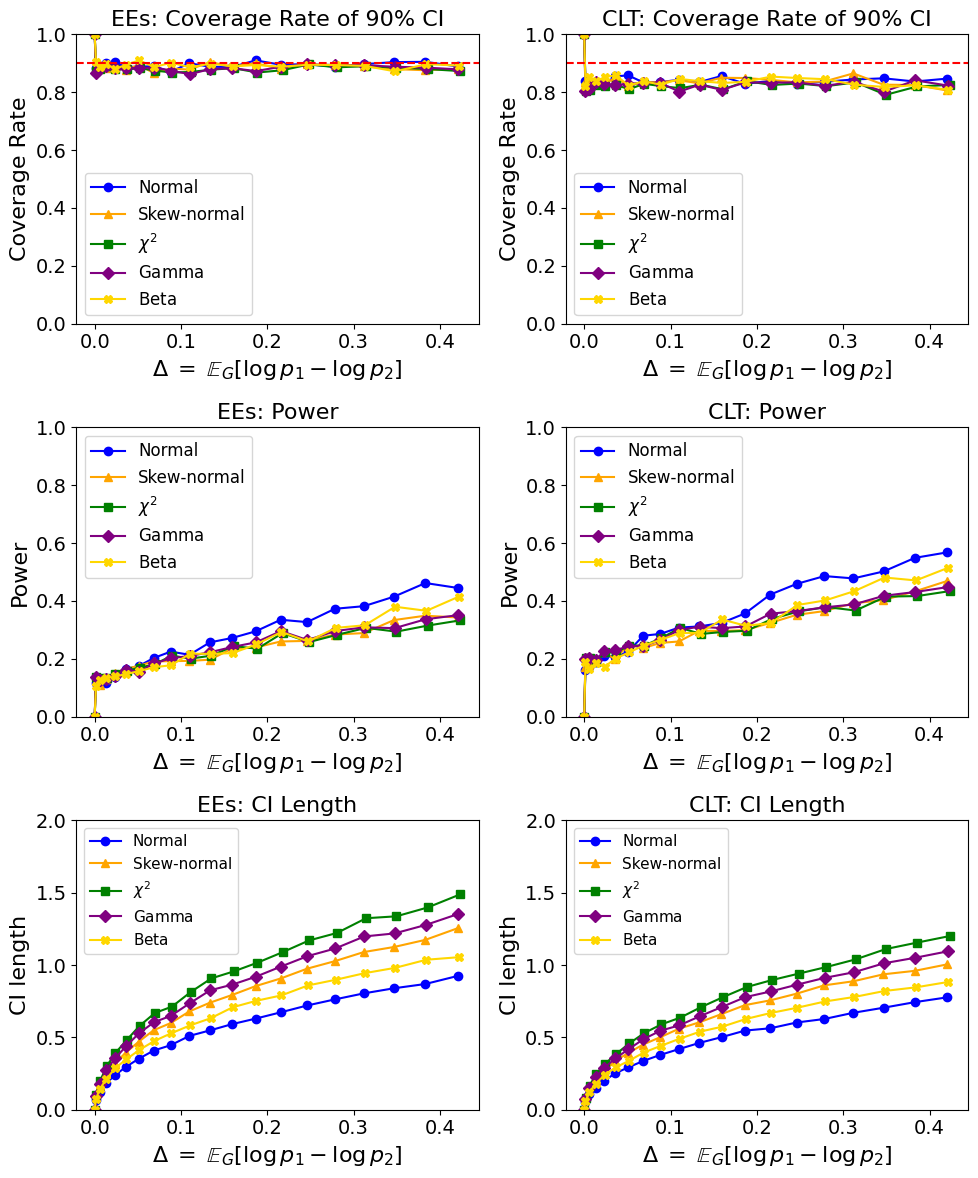

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^', 'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue', 
    'skewnorm': 'orange', 
    'chi2': 'green', 
    'gamma': 'purple', 
    'beta': 'gold' 
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})


for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0,2)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 2)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

plt.tight_layout()
plt.savefig("linear_unknown_final.eps", dpi=500)
plt.savefig("linear_unknown_final.png", dpi=500)
plt.show()

### 1.1.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_linear_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)   
            Y0 = samplers[name]((num_data, dim), rng=rng) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]      
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0) 
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_linear_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Y1 = sampler((num_data, dim)) * A1_vector + B1_bias
            Y2 = sampler((num_data, dim)) * A2_vector + B2_bias
            Y0 = sampler((num_data, dim)) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)


results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))


metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


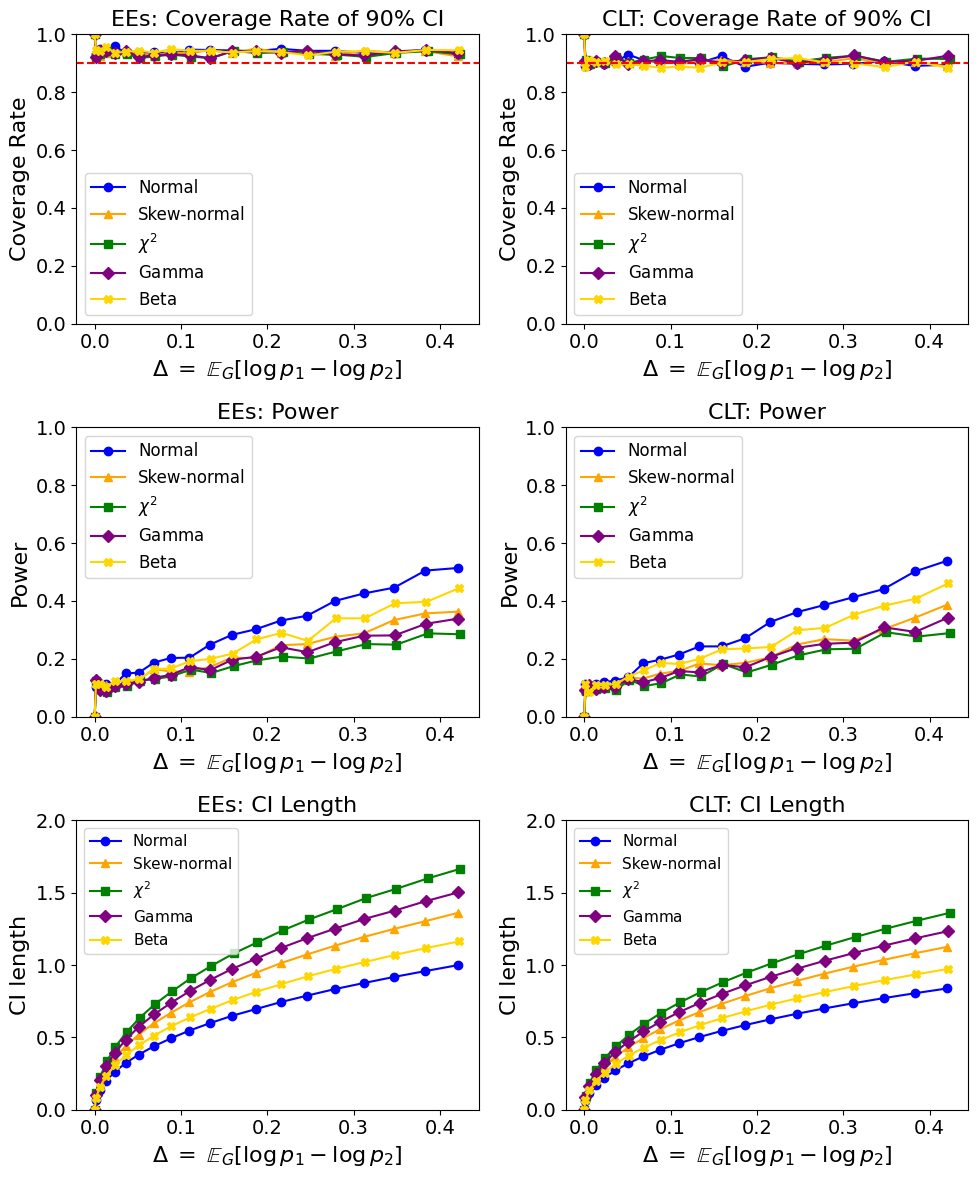

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^', 'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue', 
    'skewnorm': 'orange', 
    'chi2': 'green', 
    'gamma': 'purple', 
    'beta': 'gold' 
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)


for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0,2)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 2)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

plt.tight_layout()
plt.savefig("linear_known.eps", dpi=500)
plt.savefig("linear_known.png", dpi=500)
plt.show()

## 1.2 $g(Z)=Z^2$

In [ ]:
def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = (Z**2) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = (Z**2) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.2.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_quadratic_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        Xvar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = (Z0**2) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)
            xvar = np.var(X, ddof=0)  

            if np.allclose(xvar, 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            Xvar[rep] = xvar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)


results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]    
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0) 
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_quadratic_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_quadratic_clt_unknown'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)
        std_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z0 = sampler((num_data, dim))
            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Y1 = (Z1**2) * A1_vector + B1_bias
            Y2 = (Z2**2) * A2_vector + B2_bias
            Y0 = (Z0**2) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = (
                (-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std()
                / np.sqrt(num_data)
            )
            delta_list[seed] = delta_pp
            std_list[seed] = std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.asarray(std_list)

        if np.allclose(std_arr, 0.0):

            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr
        upper = delta_arr + z * std_arr

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_quadratic_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


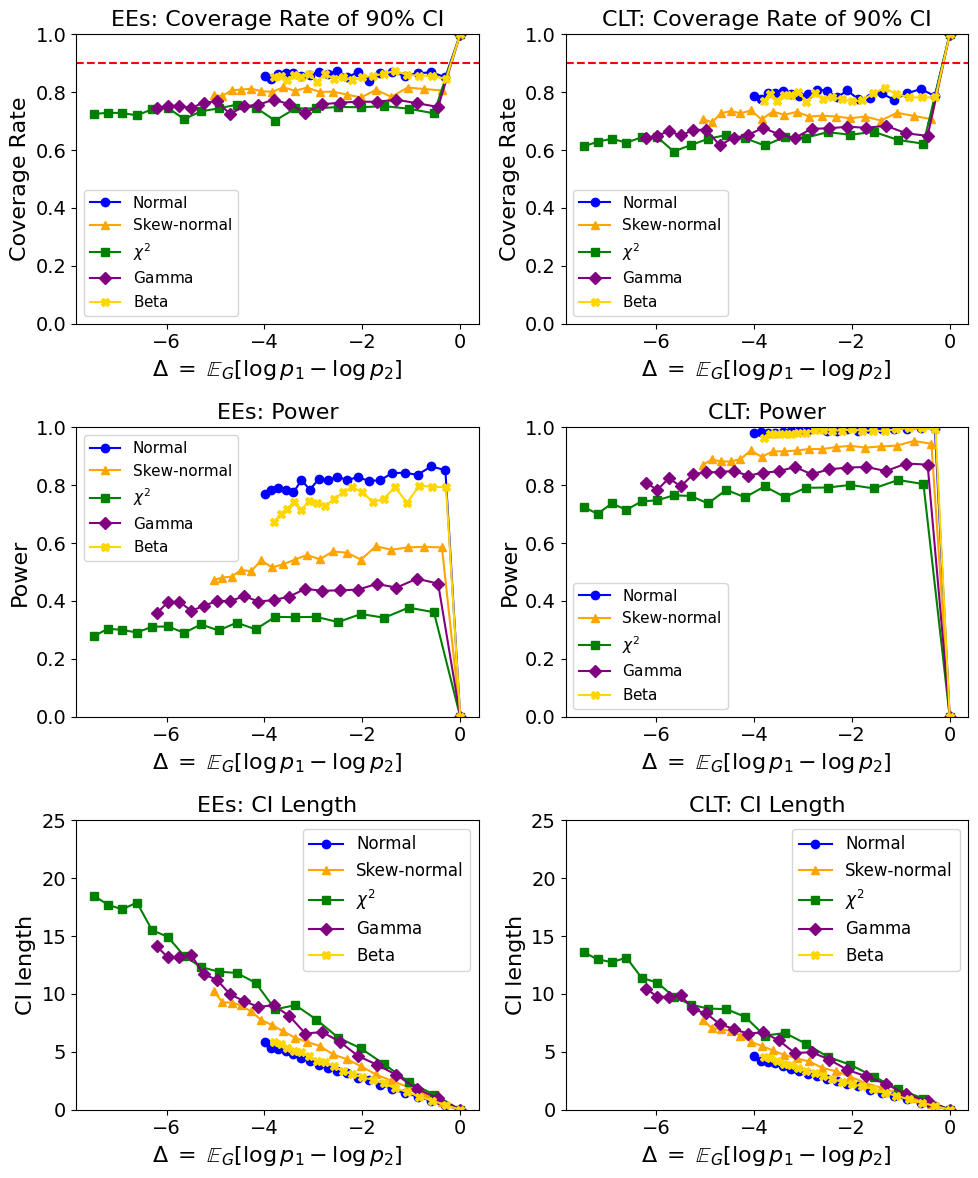

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^', 'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'  
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11})

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0,25)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 25)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

plt.tight_layout()
plt.savefig("quadratic_unknown.eps", dpi=500)
plt.savefig("quadratic_unknown.png", dpi=500)
plt.show()

### 1.2.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_quadratic_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = (Z0**2) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]   
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0) 
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_quadratic_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_quadratic_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)


        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Y1 = (sampler((num_data, dim))**2) * A1_vector + B1_bias
            Y2 = (sampler((num_data, dim))**2) * A2_vector + B2_bias
            Y0 = (sampler((num_data, dim))**2) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):

            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))


metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_quadratic_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


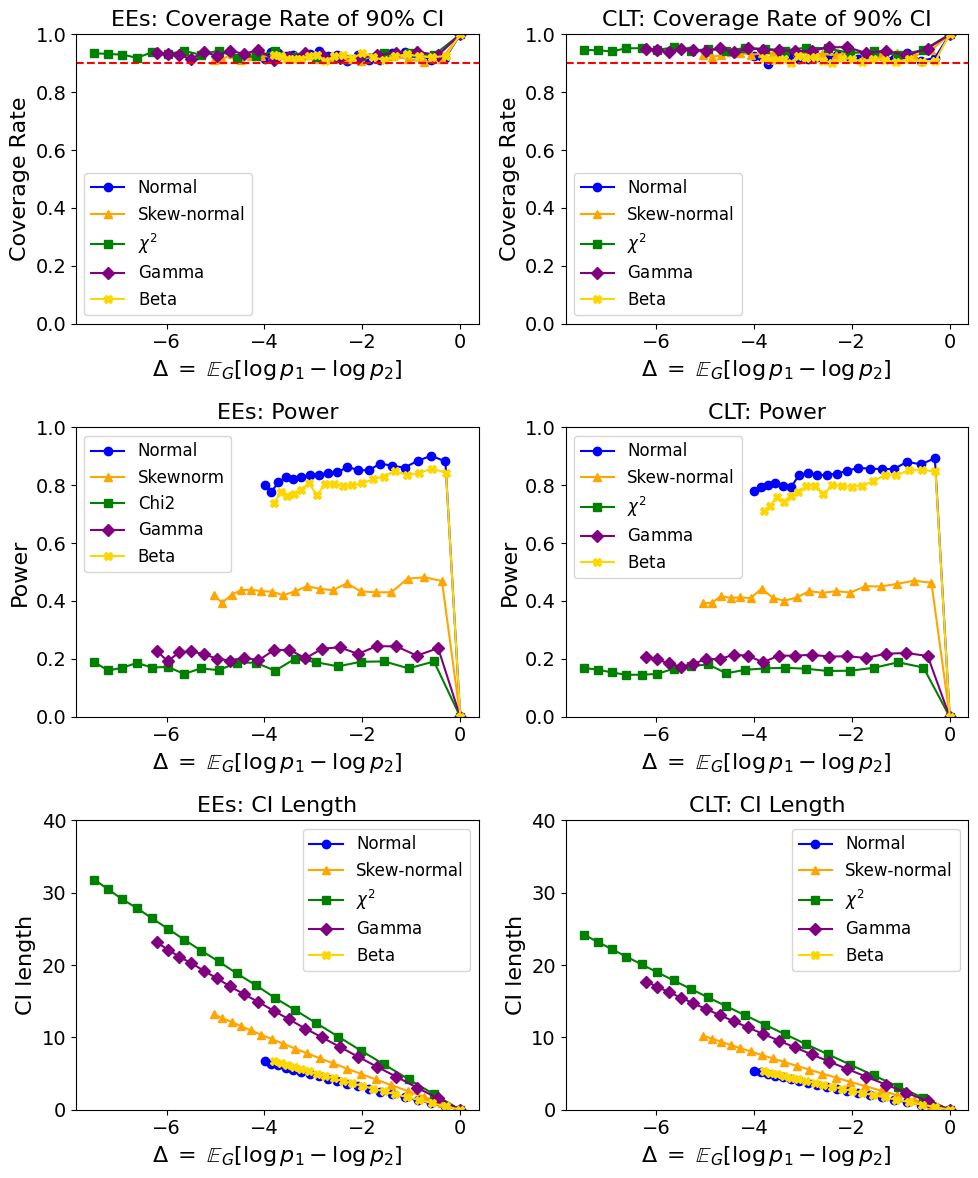

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^', 'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(prop={'size': 12})

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0,40)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 40)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'],prop={'size': 12})

plt.tight_layout()
plt.savefig("quadratic_known.png", dpi=500)
plt.savefig("quadratic_known.eps", dpi=500)
plt.show()

## 1.3 $g(Z)=sin(2\pi Z)$

In [ ]:
def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.sin(2 * np.pi * Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.sin(2 * np.pi * Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])

### 1.3.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_sin2p_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        Xvar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.sin(2 * np.pi * Z0) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)
            xvar = np.var(X, ddof=0)

            if np.allclose(xvar, 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            Xvar[rep] = xvar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]    
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sin2p_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_sin2p_clt_unknown'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)
        std_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z0 = sampler((num_data, dim))
            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Y1 = np.sin(2 * np.pi * Z1) * A1_vector + B1_bias
            Y2 = np.sin(2 * np.pi * Z2) * A2_vector + B2_bias
            Y0 = np.sin(2 * np.pi * Z0) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = (
                (-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std()
                / np.sqrt(num_data)
            )
            delta_list[seed] = delta_pp
            std_list[seed] = std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr
        upper = delta_arr + z * std_arr

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sin2p_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


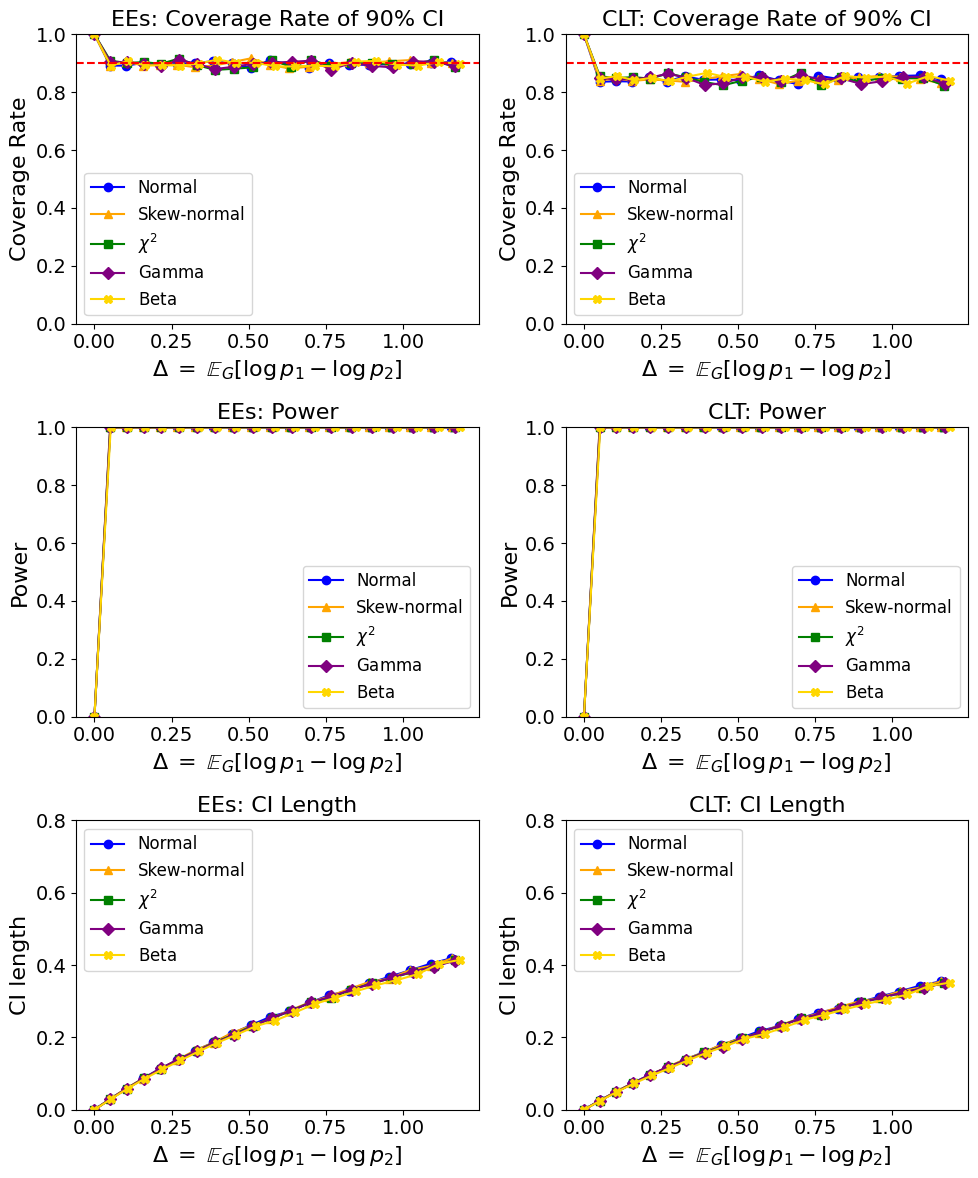

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^', 'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal','Skew-normal',r'$\chi^2$',r'$\mathrm{Gamma}$',r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12},loc = 'lower right')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0,0.8)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 0.8)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc = 'upper left')

plt.tight_layout()
plt.savefig("sin2p_unknown.png", dpi=500)
plt.savefig("sin2p_unknown.eps", dpi=500)
plt.show()

### 1.3.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_sin2p_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep) 
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.sin(2 * np.pi * Z0) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]   
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sin2p_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_sin2p_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)


        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))
            Y1 = np.sin(2 * np.pi * Z1) * A1_vector + B1_bias
            Y2 = np.sin(2 * np.pi * Z2) * A2_vector + B2_bias
            Y0 = np.sin(2 * np.pi * Z0) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp


        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)


results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sin2p_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


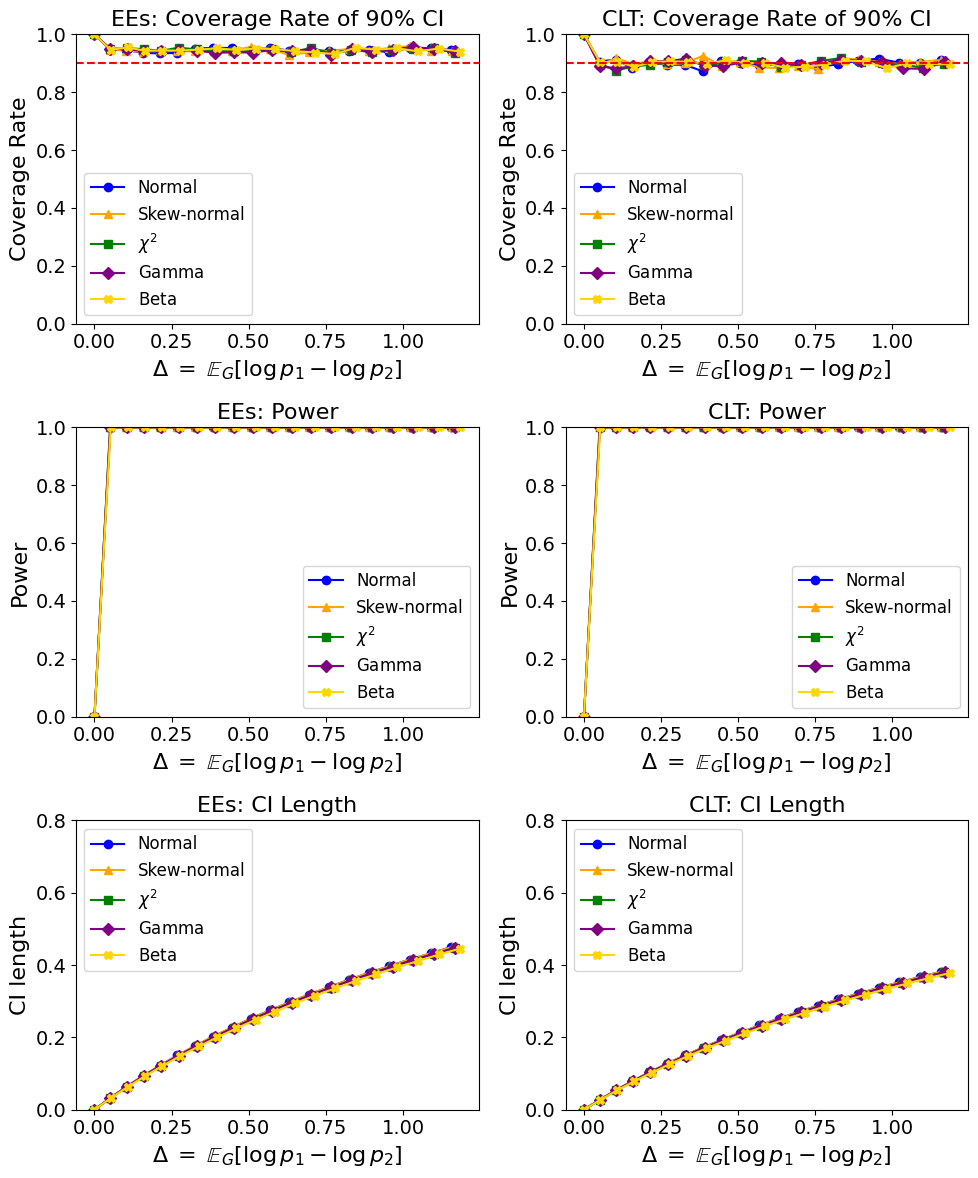

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)


for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})


for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 0.8)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 0.8)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper left')

plt.tight_layout()
plt.savefig("sin2p_known.png", dpi=500)
plt.savefig("sin2p_known.eps", dpi=500)
plt.show()

## 1.4 $g(Z)=\text{Sigmoid}(Z)$

In [ ]:
def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    sigmoid = 1.0 / (1.0 + np.exp(-Z))
    Y = sigmoid * A1_vec + B1 
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    sigmoid = 1.0 / (1.0 + np.exp(-Z))
    Y = sigmoid * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.4.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_sigmoid_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            Y0 = sigmoid0 * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar 

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees_sigmoid.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees_sigmoid.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH         = './result_sigmoid_clt'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            sigmoid2 = 1.0 / (1.0 + np.exp(-Z2))
            Y0 = sigmoid0 * A1_vector + B1_bias
            Y2 = sigmoid2 * A2_vector + B2_bias  

            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result_sigmoid.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result_sigmoid.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


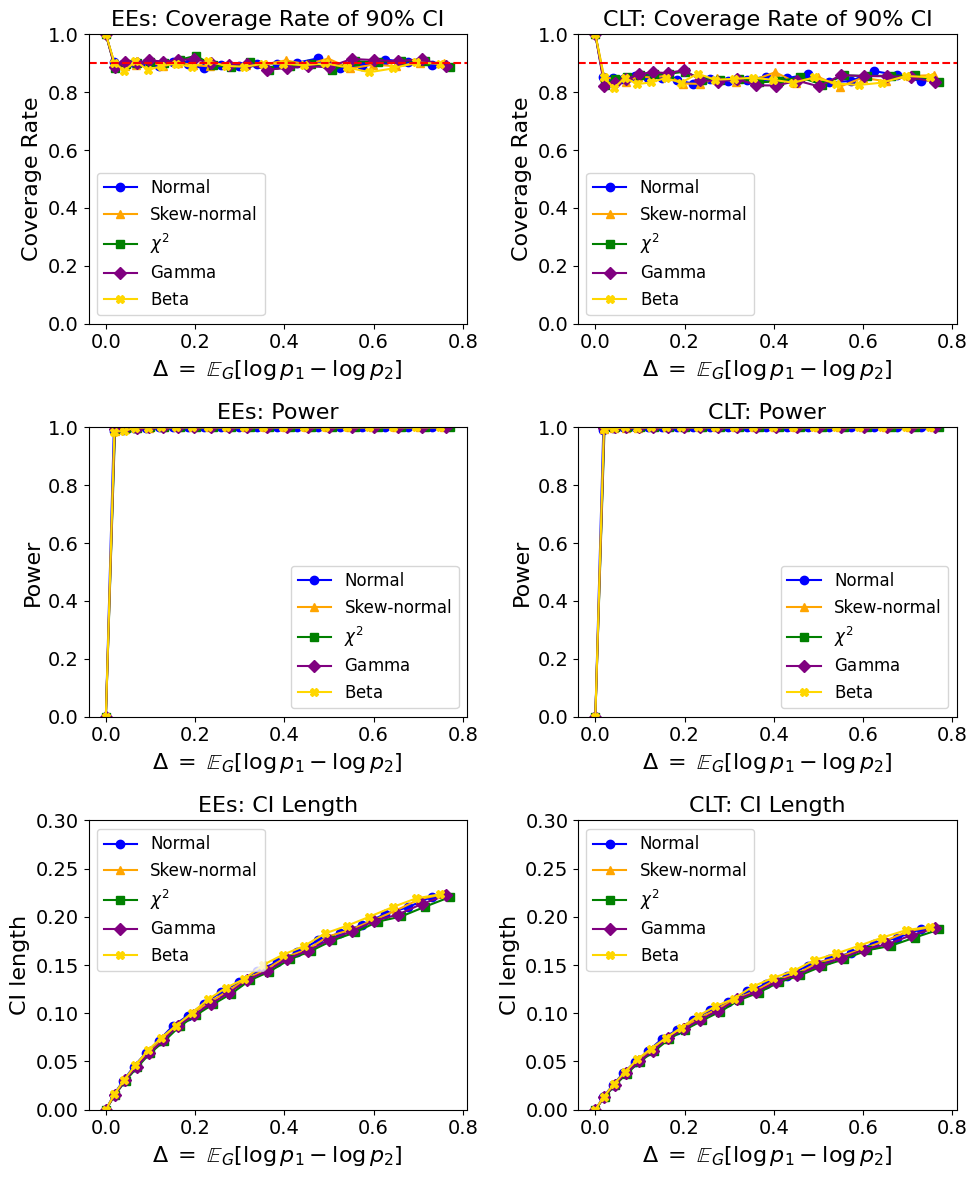

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'  
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 0.3)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12},loc = 'upper left')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 0.3)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper left')

plt.tight_layout()
plt.savefig("sigmoid_unknown.png", dpi=500)
plt.savefig("sigmoid_unknown.eps", dpi=500)
plt.show()

### 1.4.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_sigmoid_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            Y0 = sigmoid0 * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]     
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_sigmoid_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))

            sigmoid1 = 1.0 / (1.0 + np.exp(-Z1))
            sigmoid2 = 1.0 / (1.0 + np.exp(-Z2))
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            Y1 = sigmoid1 * A1_vector + B1_bias
            Y2 = sigmoid2 * A2_vector + B2_bias
            Y0 = sigmoid0 * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)


results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):

            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


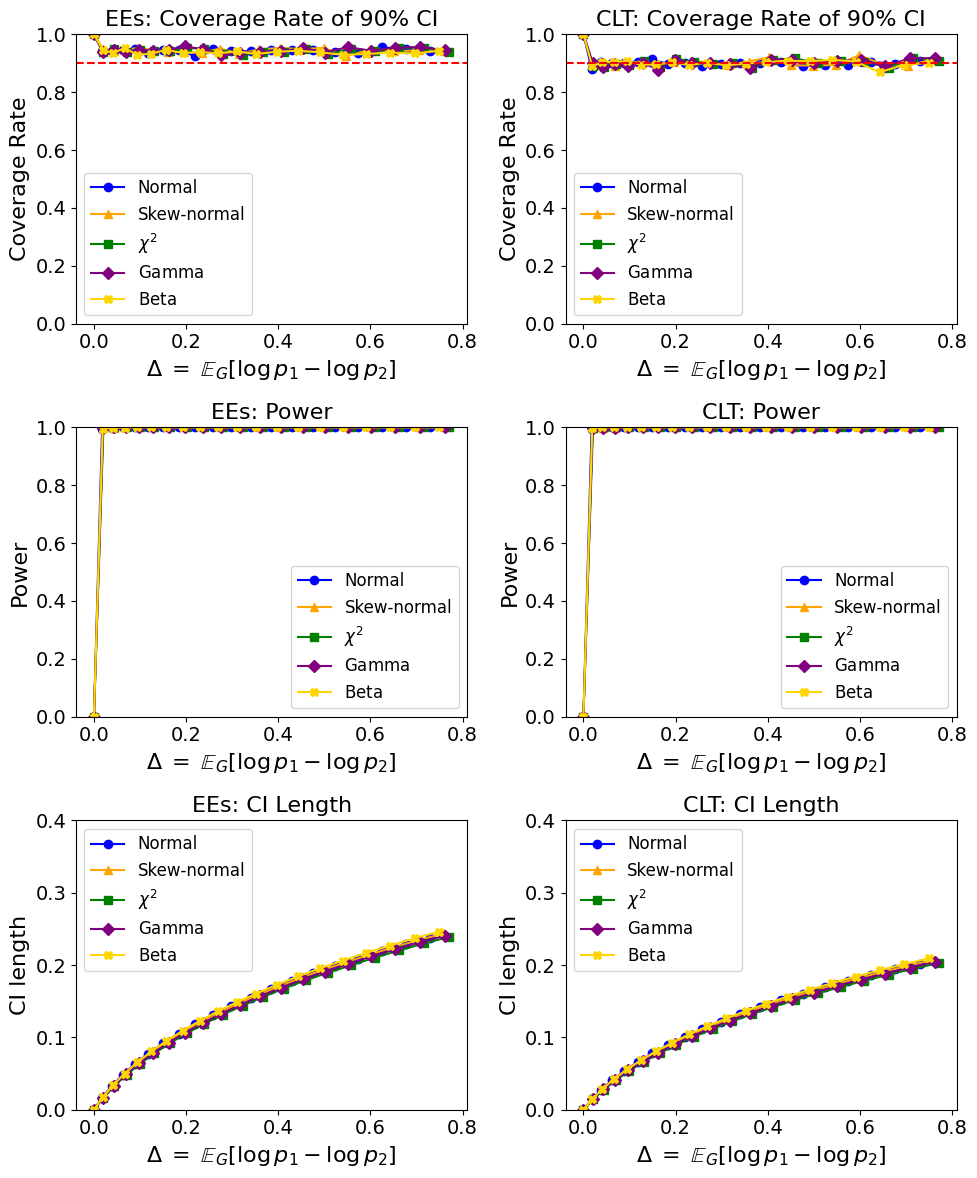

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower right')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 0.4)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper left')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 0.4)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper left')

plt.tight_layout()
plt.savefig("sigmoid_known.png", dpi=500)
plt.savefig("sigmoid_known.eps", dpi=500)
plt.show()

## 1.5 $g(Z)=\text{Logit}(Z)$

In [ ]:
from scipy.special import logit  
def logit_transform(Z):
    prob_Z = norm.cdf(Z)
    clipped_prob_Z = np.clip(prob_Z, 1e-9, 1 - 1e-9)
    return logit(clipped_prob_Z)


def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = logit_transform(Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = logit_transform(Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.5.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_logit_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = logit_transform(Z0) * A1_vector + B1_bias   
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar 

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_logit_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH         = './result_logit_clt'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            Y0 = logit_transform(Z0) * A1_vector + B1_bias
            Y2 = logit_transform(Z2) * A2_vector + B2_bias  
            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_logit_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


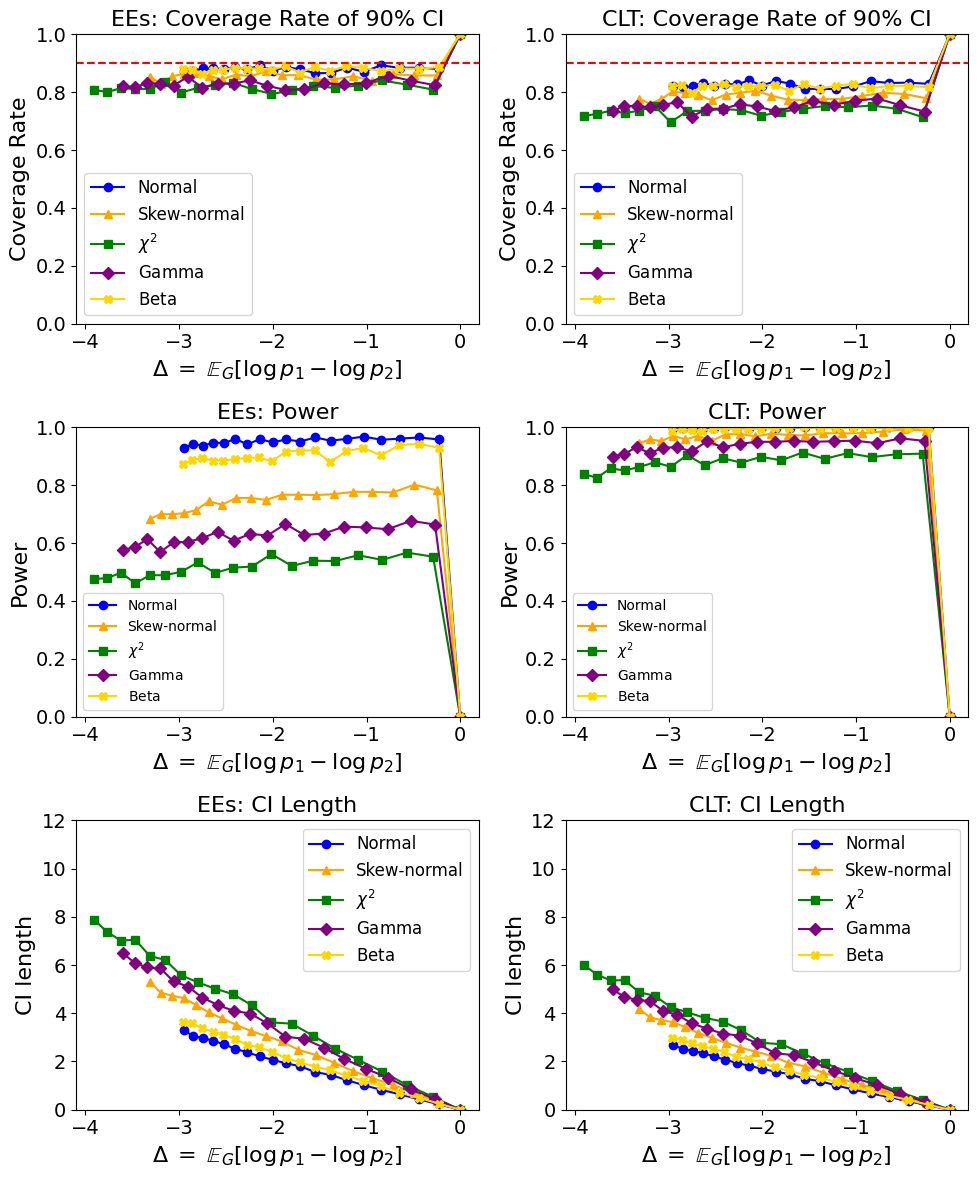

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'  
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 10}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 10}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 12)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12},loc = 'upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 12)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("logit_unknown.eps", dpi=500)
plt.savefig("logit_unknown.png", dpi=500)
plt.show()

### 1.4.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_logit_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep) 
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = logit_transform(Z0) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]      
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):

            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0) 
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_logit_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_logit_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))

            Y1 = logit_transform(Z1) * A1_vector + B1_bias
            Y2 = logit_transform(Z2) * A2_vector + B2_bias
            Y0 = logit_transform(Z0) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_logit_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


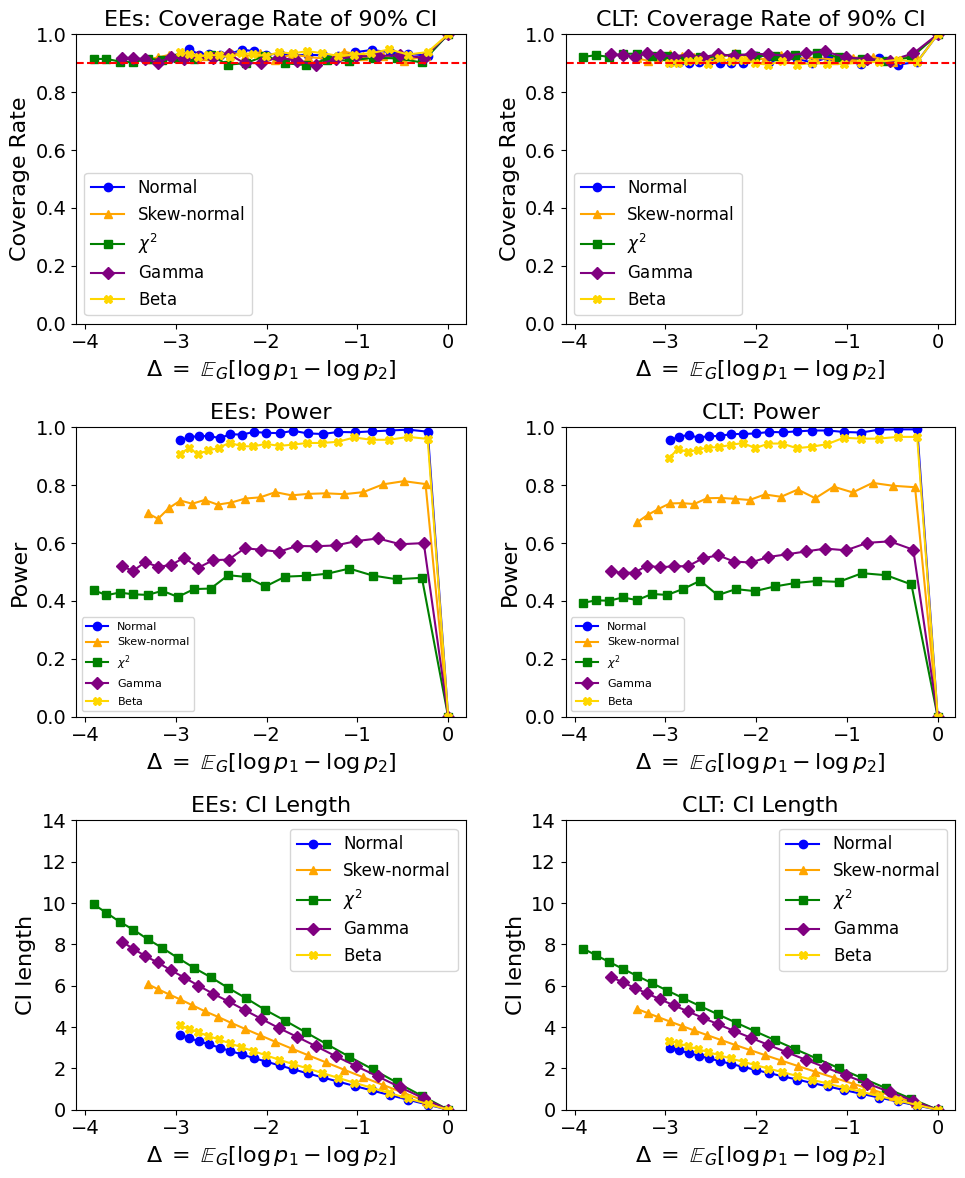

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 8}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 8}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 14)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 14)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("logit_known.eps", dpi=500)
plt.savefig("logit_known.png", dpi=500)
plt.show()

##  1.6 $g(Z)=\text{ReLu}(Z)$

In [ ]:
def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.maximum(0, Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.maximum(0, Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.6.1 unkown variance

#### EEs

In [ ]:
PATH_EES = './result_relu_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.maximum(0, Z0) * A1_vector + B1_bias 
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_relu_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH         = './result_relu_clt'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            Y0 = np.maximum(0, Z0) * A1_vector + B1_bias
            Y2 = np.maximum(0, Z2) * A2_vector + B2_bias   
            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_relu_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


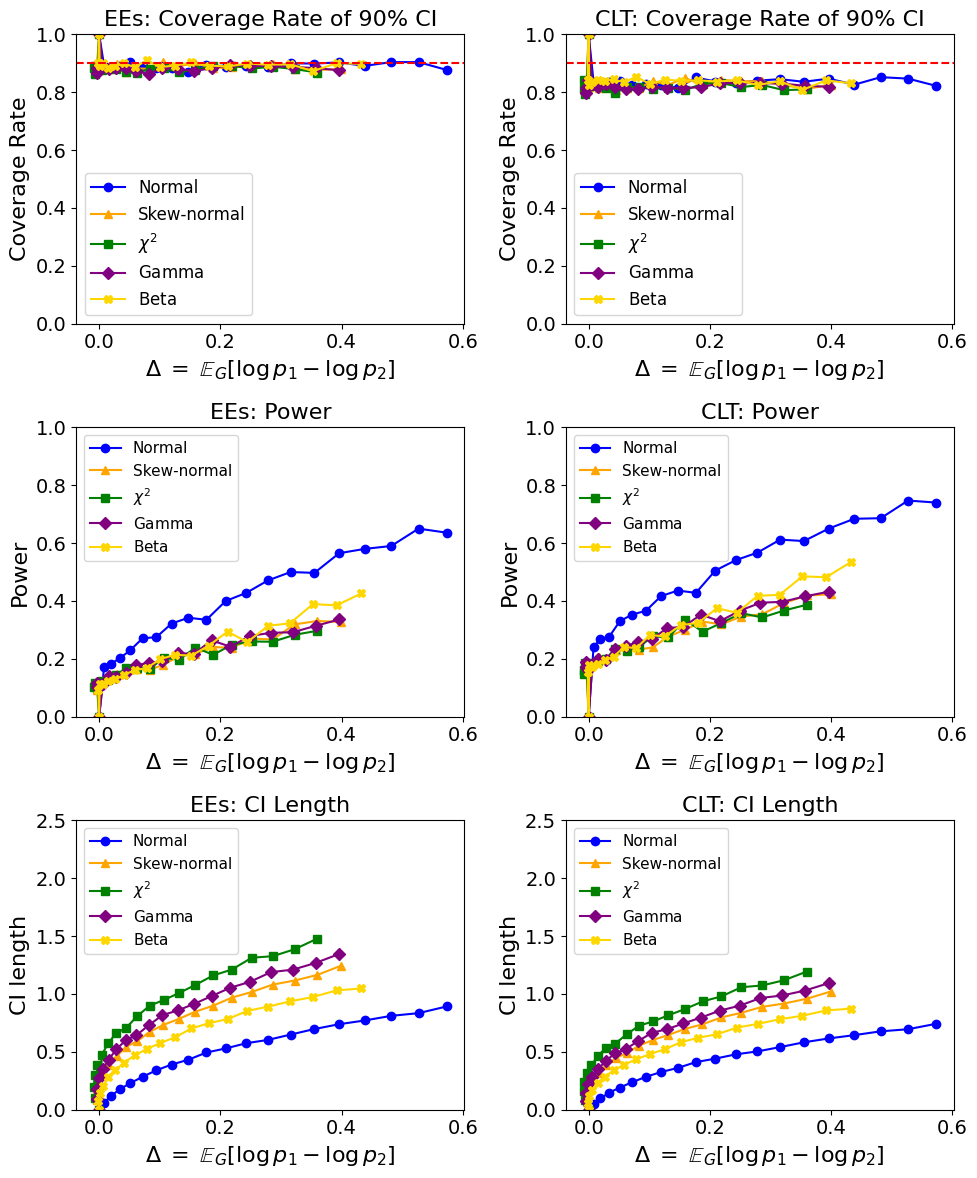

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 2.5)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11},loc = 'upper left')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 2.5)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

plt.tight_layout()
plt.savefig("relu_unknown.png", dpi=500)
plt.savefig("relu_unknown.eps", dpi=500)
plt.show()

### 1.6.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_relu_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.maximum(0, Z0) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]   
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_relu_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_relu_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))
            Y1 = np.maximum(0, Z1) * A1_vector + B1_bias
            Y2 = np.maximum(0, Z2) * A2_vector + B2_bias
            Y0 = np.maximum(0, Z0) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            delta_list[seed] = delta_pp


        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_relu_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


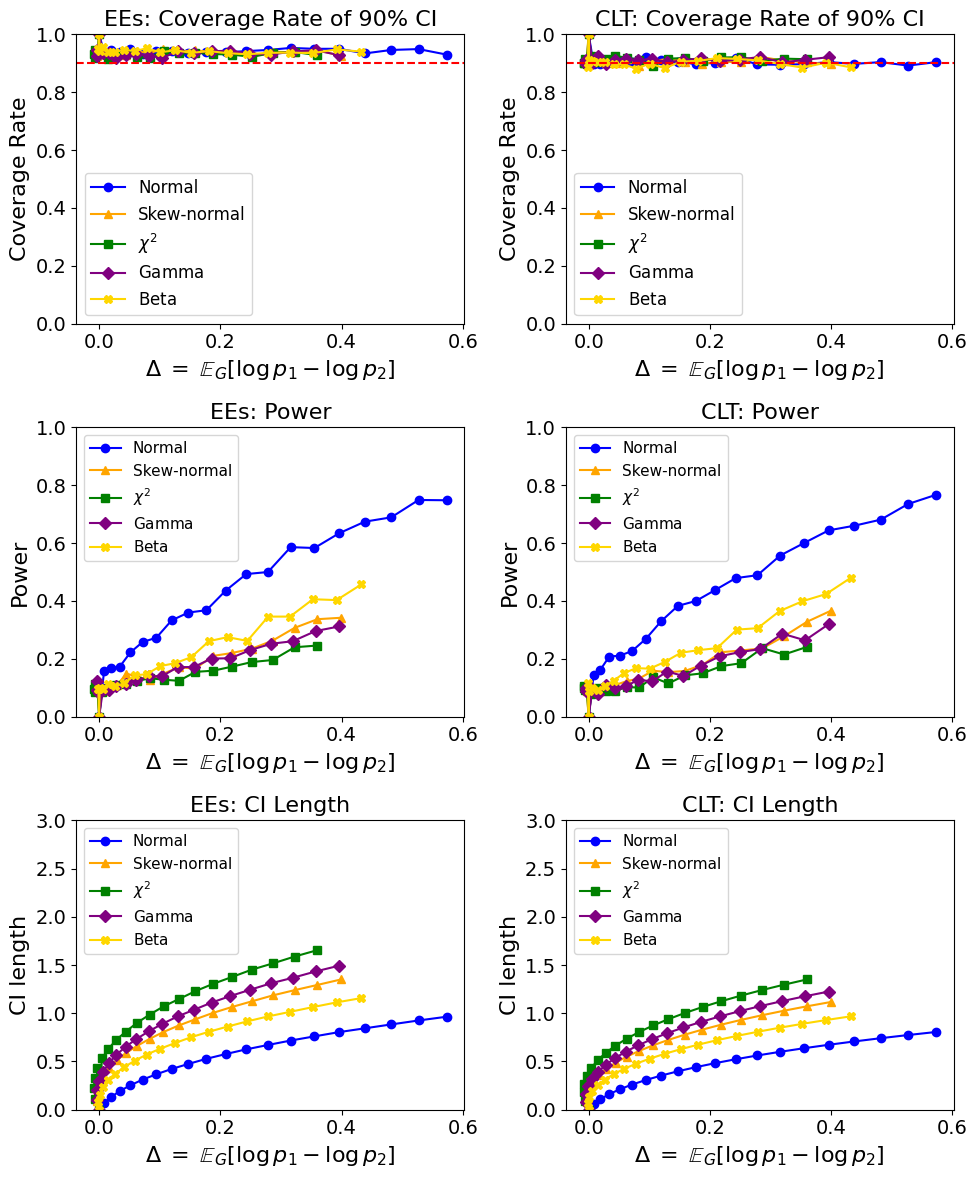

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 3)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 3)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 11}, loc='upper left')

plt.tight_layout()
plt.savefig("relu_known.png", dpi=500)
plt.savefig("relu_known.eps", dpi=500)
plt.show()

## 1.7 $g(Z)=\sigma(A \odot\sigma(A \odot\sigma(Z)+B)+B)$

In [ ]:
class MLP3Layer:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, seed=2024):
        rng = np.random.RandomState(seed)
        self.W1 = rng.randn(input_dim, hidden_dim1)
        self.b1 = rng.randn(hidden_dim1)
        self.W2 = rng.randn(hidden_dim1, hidden_dim2)
        self.b2 = rng.randn(hidden_dim2)
        self.W3 = rng.randn(hidden_dim2, output_dim)
        self.b3 = rng.randn(output_dim)
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, Z):
        L1 = self._sigmoid(Z @ self.W1 + self.b1)
        L2 = self._sigmoid(L1 @ self.W2 + self.b2)
        output = L2 @ self.W3 + self.b3
        return output

mlp_transform = MLP3Layer(input_dim=10, hidden_dim1=16,
                          hidden_dim2=8, output_dim=10)


def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = mlp_transform.forward(Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = mlp_transform.forward(Z) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))


TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.7.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_3sigmoid_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = mlp_transform.forward(Z0) * A1_vector + B1_bias   
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar 

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_3sigmoid_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH  = './result_3sigmoid_clt'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            Y0 = mlp_transform.forward(Z0)  * A1_vector + B1_bias
            Y2 = mlp_transform.forward(Z2)  * A2_vector + B2_bias   
            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_3sigmoid_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


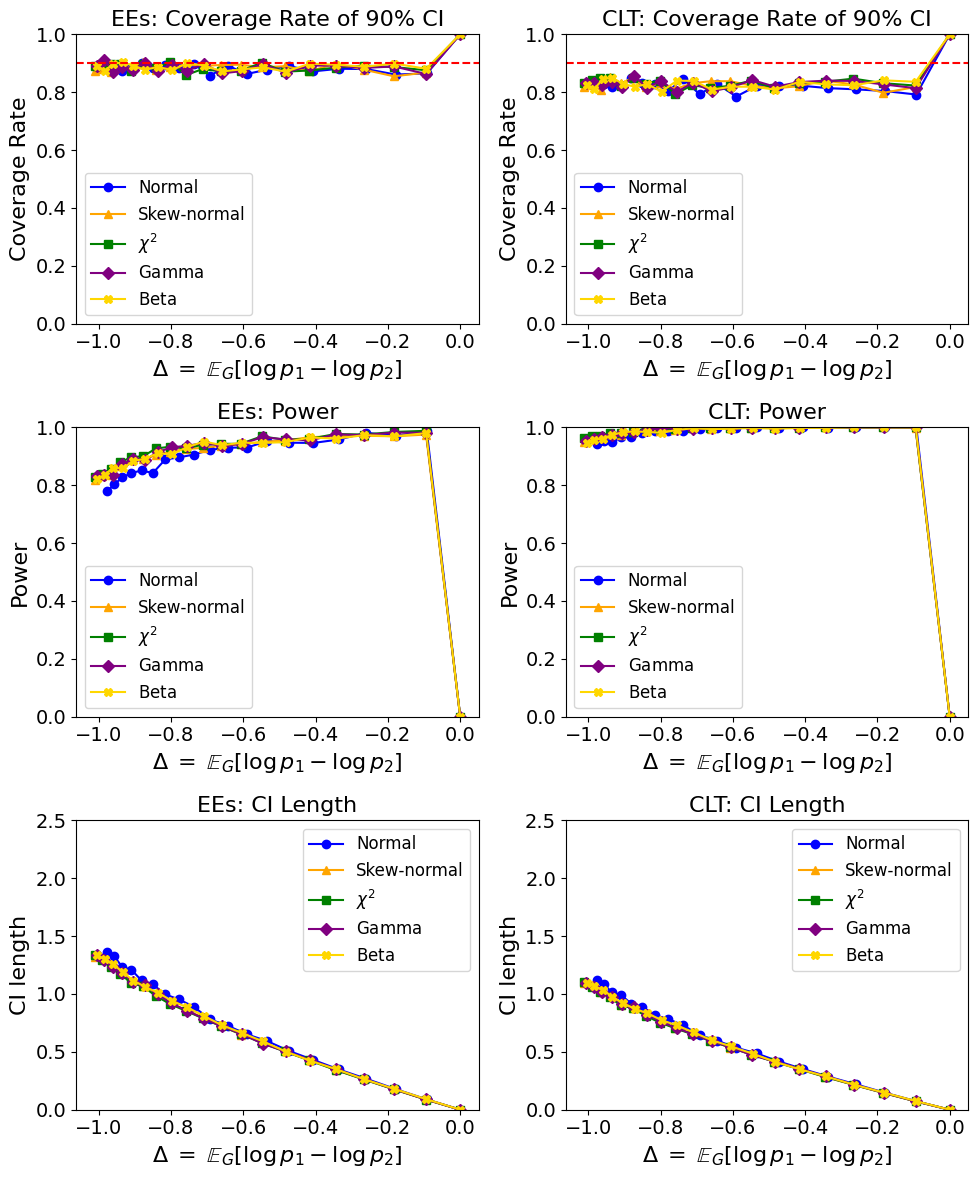

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 2.5)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 2.5)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("3sigmoid_unknown.png", dpi=500)
plt.savefig("3sigmoid_unknown.eps", dpi=500)
plt.show()

### 1.7.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_3sigmoid_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = mlp_transform.forward(Z0) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]     
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)  
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_3sigmoid_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_3sigmoid_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))
            
            Y1 = mlp_transform.forward(Z1) * A1_vector + B1_bias
            Y2 = mlp_transform.forward(Z2) * A2_vector + B2_bias
            Y0 = mlp_transform.forward(Z0) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )

            delta_list[seed] = delta_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_3sigmoid_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


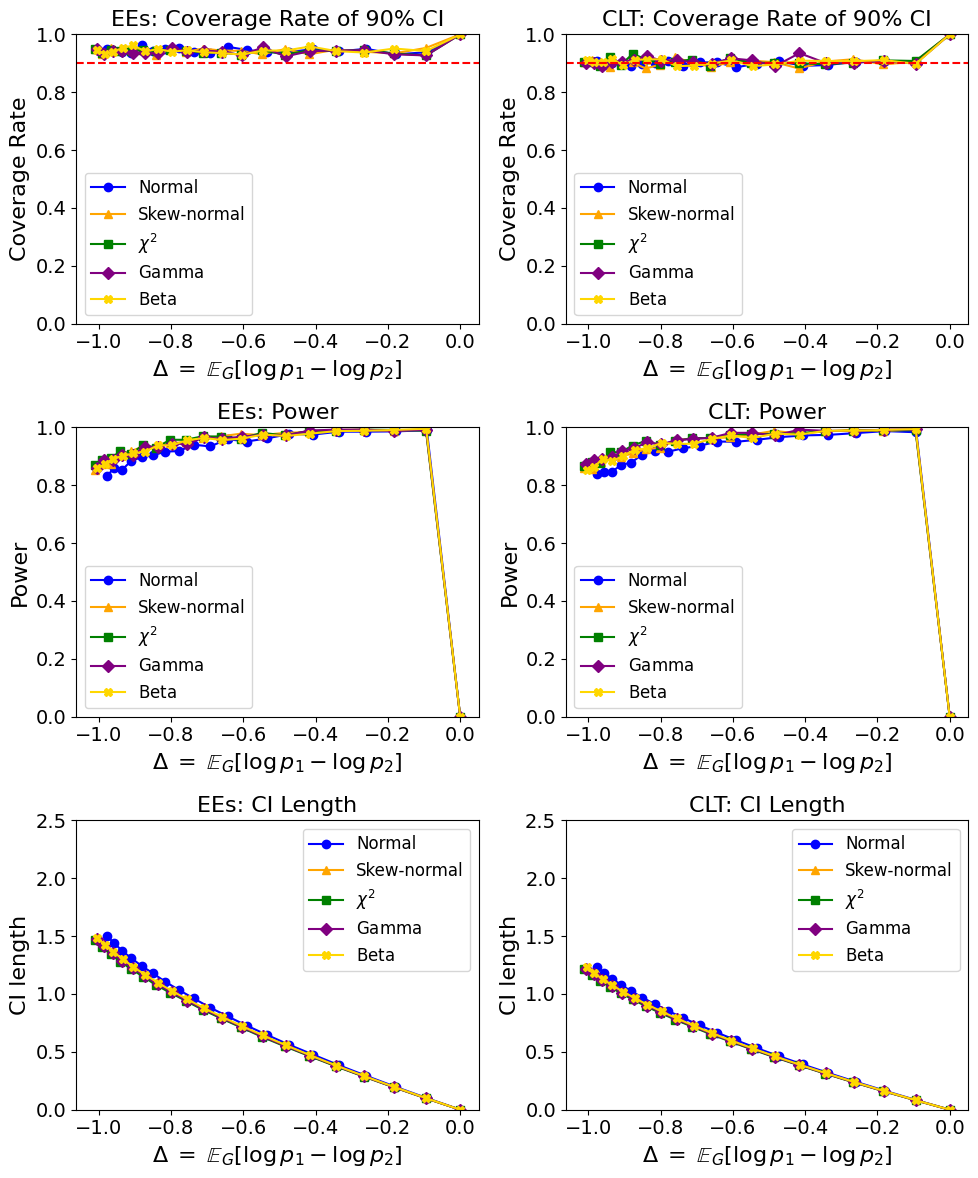

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 2.5)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 2.5)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("3sigmoid_known.png", dpi=500)
plt.savefig("3sigmoid_known.eps", dpi=500)
plt.show()

## 1.8 $g(Z)=|Z|^{3/2}$

In [ ]:
def var_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.abs(Z)**(3/2) * A1_vec + B1   
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    return float(np.var(X, ddof=0))

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = np.abs(Z)**(3/2) * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
VAR_TRUE = {name: [] for name in names}
for name in names:
    for eps in epsilon_list:
        TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
        VAR_TRUE[name].append(var_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])
    VAR_TRUE[name] = np.array(VAR_TRUE[name])

### 1.8.1 unknown variance

#### EEs

In [ ]:
PATH_EES = './result_power_ees_unknown'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.abs(Z0)**(3/2) * A1_vector + B1_bias 
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar 

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]
        n = num_data
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_power_ees_unknown.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH         = './result_power_clt'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            Y0 = np.abs(Z0)**(3/2)  * A1_vector + B1_bias
            Y2 = np.abs(Z2)**(3/2)  * A2_vector + B2_bias 
            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_epsilon_{iter_index}_result.pt", 'wb') as f:
            pickle.dump([delta_list, std_list], f)

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_result.pt", 'rb') as f:
            delta_list, std_list = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_power_clt_unknown.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


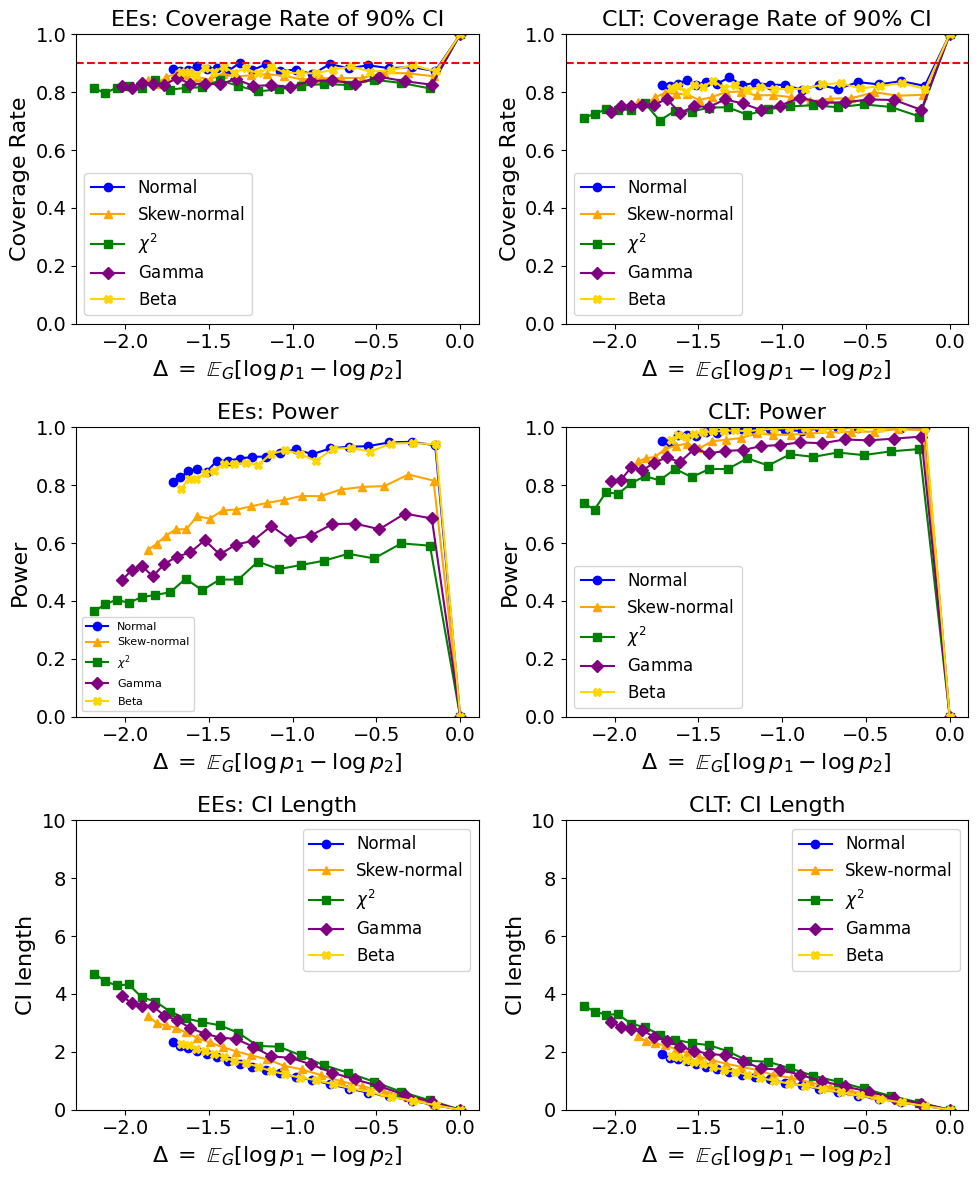

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold'  
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 8}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 10)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12},loc = 'upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 10)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("power_unknown.png", dpi=500)
plt.savefig("power_unknown.eps", dpi=500)
plt.show()

### 1.8.2 known variance

#### EEs

In [ ]:
PATH_EES = './result_power_ees_known'
os.makedirs(PATH_EES, exist_ok=True)

for name in names:
    for iter_index, eps in enumerate(epsilon_list):

        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)  
            Z0 = samplers[name]((num_data, dim), rng=rng)
            Y0 = np.abs(Z0)**(3/2) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)

            if np.allclose(np.var(X, ddof=1), 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_epsilon_{iter_index}_ees.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, K3, K4, float(eps)], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH_EES}/{name}_epsilon_{i}_ees.pt", 'rb') as f:
            C_const, Xbar, K3, K4, eps_val = pickle.load(f)

        td = TRUE[name][i]     
        n = num_data
        sigma_known = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(sigma_known, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_known/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_known/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_known

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_knownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_knownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)  
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_power_ees.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
PATH = './result_power_clt_known'
os.makedirs(PATH, exist_ok=True)

for name, sampler in samplers.items():
    for iter_index, eps in enumerate(epsilon_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)

            Z1 = sampler((num_data, dim))
            Z2 = sampler((num_data, dim))
            Z0 = sampler((num_data, dim))

            Y1 = np.abs(Z1)**(3/2) * A1_vector + B1_bias
            Y2 = np.abs(Z2)**(3/2) * A2_vector + B2_bias
            Y0 = np.abs(Z0)**(3/2) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            delta_list[seed] = delta_pp


        with open(f"{PATH}/{name}_epsilon_{iter_index}_clt.pt", 'wb') as f:
            pickle.dump([delta_list], f)


results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, eps in enumerate(epsilon_list):
        with open(f"{PATH}/{name}_epsilon_{i}_clt.pt", 'rb') as f:
            delta_list = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.sqrt(VAR_TRUE[name][i])

        if np.isclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name][i]
        lower = delta_arr - z * std_arr/np.sqrt(num_data)
        upper = delta_arr + z * std_arr/np.sqrt(num_data)

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_power_clt.pt", 'wb') as f:
    pickle.dump(results_clt, f)

### plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


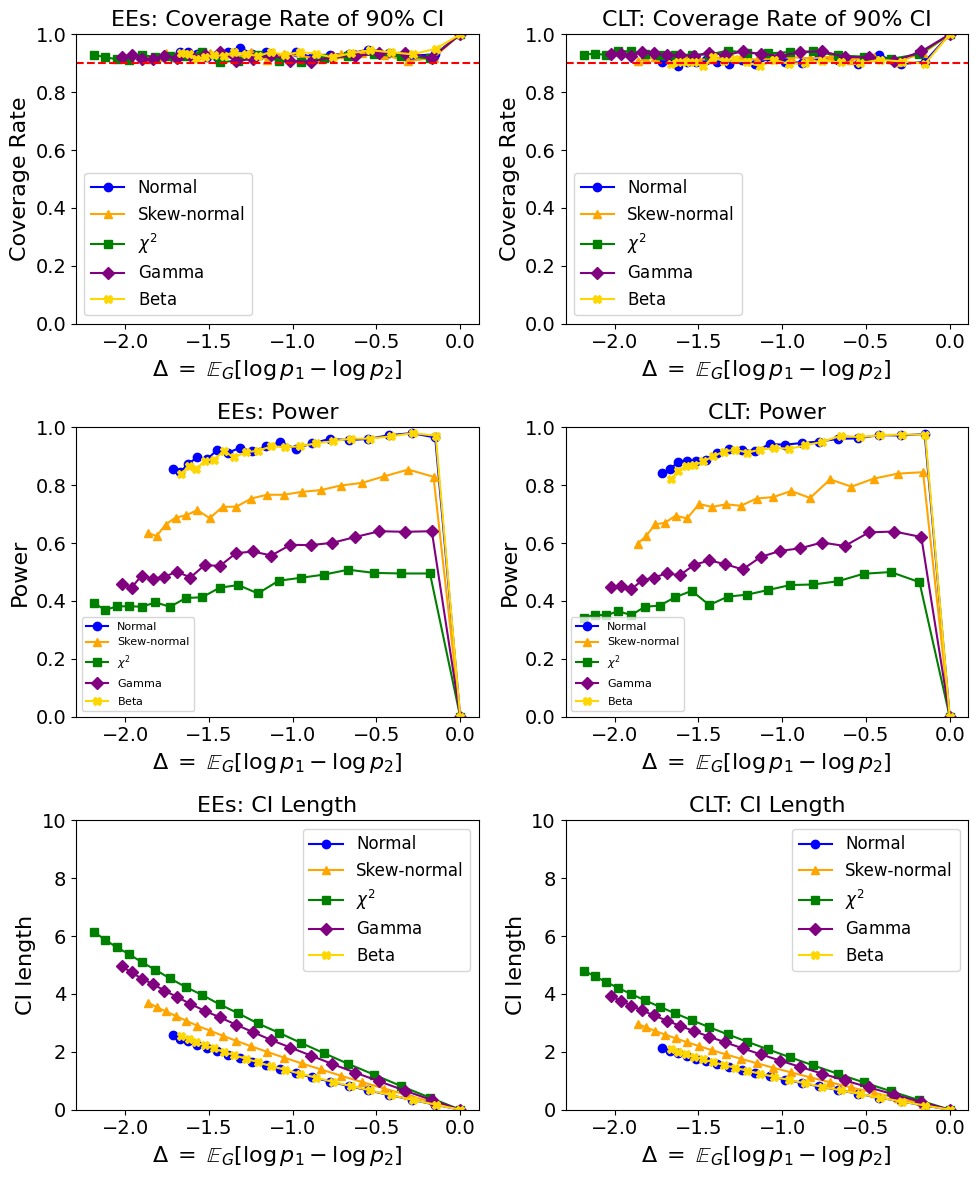

In [ ]:
markers = {'normal': 'o', 'skewnorm': '^',
           'chi2': 's', 'gamma': 'D', 'beta': 'X'}
colors = {
    'normal': 'blue',
    'skewnorm': 'orange',
    'chi2': 'green',
    'gamma': 'purple',
    'beta': 'gold' 
}


fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=False)

for name in names:
    cov, _, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 0].plot(x, cov[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[0, 0].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 0].set_ylabel('Coverage Rate')
axes[0, 0].set_title('EEs: Coverage Rate of 90% CI')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    cov, _, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[0, 1].plot(x, cov[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[0, 1].axhline(1-alpha, color='red', linestyle='--',
                   label=f'Level {1-alpha:.2f}')
axes[0, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[0, 1].set_ylabel('Coverage Rate')
axes[0, 1].set_title('CLT: Coverage Rate of 90% CI')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12})

for name in names:
    _, pwr, _ = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 0].plot(x, pwr[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[1, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('EEs: Power')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 8}, loc='lower left')

for name in names:
    _, pwr, _ = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[1, 1].plot(x, pwr[order], marker=markers[name],
                    label=name.capitalize(), color=colors[name])
axes[1, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('CLT: Power')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 8}, loc='lower left')

for name in names:
    _, _, CI_len = results_ees[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 0].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 0].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 0].set_ylabel('CI length')
axes[2, 0].set_title('EEs: CI Length')
axes[2, 0].set_ylim(0, 10)
axes[2, 0].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

for name in names:
    _, _, CI_len = results_clt[name]
    order = np.argsort(TRUE[name])
    x = TRUE[name][order]
    axes[2, 1].plot(x, CI_len[order], marker=markers[name], label=name.capitalize(),
                    color=colors[name])
axes[2, 1].set_xlabel(r'$\Delta \;=\; \mathbb{E}_G[\log p_1 - \log p_2]$')
axes[2, 1].set_ylabel('CI length')
axes[2, 1].set_title('CLT: CI Length')
axes[2, 1].set_ylim(0, 10)
axes[2, 1].legend(['Normal', 'Skew-normal', r'$\chi^2$',
                  r'$\mathrm{Gamma}$', r'$\mathrm{Beta}$'], prop={'size': 12}, loc='upper right')

plt.tight_layout()
plt.savefig("power_known.png", dpi=500)
plt.savefig("power_known.eps", dpi=500)
plt.show()

# 2. optimal $n$


### (1) $g(Z)=Z$, unknown variance

#### EES

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm, skew, kurtosis, expon
import pickle
from scipy.stats import skewnorm, norm, expon, chi2, gamma, beta

def edgeworth_unknownvar_cdf(x, n, kappa3, kappa4):  
    x = np.asarray(x, dtype=float)
    Phi = norm.cdf(x)
    phi = norm.pdf(x)

    term1 = (n**-0.5) * (kappa3 / 6.0) * (2*x**2 + 1) * phi
    term2 = (n**-1.0) * ((kappa4 / 12.0) * x * (x**2 - 3) -
                         (kappa3**2 / 18.0) * x * (x**4 + 2*x**2 - 3) - 1 / 4.0 * x * (x**2 + 3)) * phi
    Fn = Phi + term1 + term2
    return np.clip(Fn, 1e-12, 1-1e-12)

def xi_from_g(Y0, A1_vec, B1, A2_vec, B2):
    g1 = (Y0 - B1) / A1_vec
    g2 = (Y0 - B2) / A2_vec
    return -0.5 * np.sum(g1**2, axis=1) + 0.5 * np.sum(g2**2, axis=1)

np.random.seed(1)
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10]))
dim = 10
A1_vector = np.random.uniform(0.8, 1.2, dim)
B1_bias = np.random.normal(0, 1, dim)
eps = 0.07
alpha = 0.1
PATH_EES = './result_linear_ees_unknown_optimal0.07'
os.makedirs(PATH_EES, exist_ok=True)

a = 5
m = skewnorm.mean(a)
s = skewnorm.std(a)
chi2_df = 5
gamma_shape = 4.0  
gamma_scale = 1.0  
beta_a = 2.0
beta_b = 5.0 
m_chi2 = chi2.mean(df=chi2_df)
s_chi2 = chi2.std(df=chi2_df)
m_gamma = gamma.mean(a=gamma_shape, scale=gamma_scale)
s_gamma = gamma.std(a=gamma_shape, scale=gamma_scale)
m_beta = beta.mean(a=beta_a, b=beta_b)
s_beta = beta.std(a=beta_a, b=beta_b)
samplers = {
    'normal': lambda size, rng=None: (rng or np.random).normal(0, 1, size),
    'skewnorm': lambda size, rng=None: (skewnorm.rvs(a=a, size=size, random_state=rng) - m) / s,
    'chi2': lambda size, rng=None: ((rng or np.random).chisquare(df=chi2_df, size=size) - m_chi2) / s_chi2,
    'gamma': lambda size, rng=None: ((rng or np.random).gamma(shape=gamma_shape, scale=gamma_scale, size=size) - m_gamma) / s_gamma,
    'beta': lambda size, rng=None: ((rng or np.random).beta(a=beta_a, b=beta_b, size=size) - m_beta) / s_beta,
}
names = ['normal', 'skewnorm','chi2', 'gamma', 'beta']

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = Z * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
for name in names:
    TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])

for name in names:
    for iter_index, num_data in enumerate(num_list):
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar = np.zeros(num_rep)
        Xvar = np.zeros(num_rep)
        K3 = np.zeros(num_rep)
        K4 = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)   
            Y0 = samplers[name]((num_data, dim), rng=rng) * A1_vector + B1_bias
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            xbar = np.mean(X)
            xvar = np.var(X, ddof=0) 

            if np.allclose(xvar, 0.0):
                k3 = 0.0
                k4 = 0.0
            else:
                k3 = float(skew(X, bias=False))
                k4 = float(kurtosis(X, fisher=True, bias=False))

            Xbar[rep] = xbar
            Xvar[rep] = xvar
            K3[rep] = k3 if np.isfinite(k3) else 0.0
            K4[rep] = k4 if np.isfinite(k4) else 0.0

        with open(f"{PATH_EES}/{name}_num_{iter_index}_ees_optimal0.07.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps), num_data], f)

results_ees = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, num_data in enumerate(num_list):
        with open(f"{PATH_EES}/{name}_num_{i}_ees_optimal0.07.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val, n = pickle.load(f)

        td = TRUE[name]     
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo

        lower = C_const + mu_lower
        upper = C_const + mu_upper
        CI_len.append(np.mean(upper - lower))
        cov.append(np.mean((lower <= td) & (td <= upper)))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown

        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)  
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_ees_unknown_optimal0.07.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm, expon
from scipy.stats import skewnorm, norm, expon, chi2, gamma, beta

np.random.seed(1)
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10])) 
dim = 10
A1_vector = np.random.uniform(0.8, 1.2, dim)
B1_bias = np.random.normal(0, 1, dim)
eps = 0.07
alpha = 0.10
z = norm.ppf(1 - alpha/2)
PATH = './result_linear_clt_unknown_optimal0.07'
os.makedirs(PATH, exist_ok=True)


a = 5
m = skewnorm.mean(a)
s = skewnorm.std(a)
chi2_df = 5
gamma_shape = 4.0
gamma_scale = 1.0
beta_a = 2.0
beta_b = 5.0
m_chi2 = chi2.mean(df=chi2_df)
s_chi2 = chi2.std(df=chi2_df)
m_gamma = gamma.mean(a=gamma_shape, scale=gamma_scale)
s_gamma = gamma.std(a=gamma_shape, scale=gamma_scale)
m_beta = beta.mean(a=beta_a, b=beta_b)
s_beta = beta.std(a=beta_a, b=beta_b)
samplers = {
    'normal': lambda size, rng=None: (rng or np.random).normal(0, 1, size),
    'skewnorm': lambda size, rng=None: (skewnorm.rvs(a=a, size=size, random_state=rng) - m) / s,
    'chi2': lambda size, rng=None: ((rng or np.random).chisquare(df=chi2_df, size=size) - m_chi2) / s_chi2,
    'gamma': lambda size, rng=None: ((rng or np.random).gamma(shape=gamma_shape, scale=gamma_scale, size=size) - m_gamma) / s_gamma,
    'beta': lambda size, rng=None: ((rng or np.random).beta(a=beta_a, b=beta_b, size=size) - m_beta) / s_beta,
}
names = ['normal', 'skewnorm', 'chi2', 'gamma', 'beta']


def xi_from_g(Y0, A1_vec, B1, A2_vec, B2):
    g1 = (Y0 - B1) / A1_vec
    g2 = (Y0 - B2) / A2_vec
    return -0.5 * np.sum(g1**2, axis=1) + 0.5 * np.sum(g2**2, axis=1)

for name, sampler in samplers.items():
    for iter_index, num_data in enumerate(num_list):
        np.random.seed(iter_index)
        A2_vector = A1_vector * (1 + eps)
        B2_bias = B1_bias + eps

        delta_list = np.zeros(1000)
        std_list = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Y1 = sampler((num_data, dim)) * A1_vector + B1_bias
            Y2 = sampler((num_data, dim)) * A2_vector + B2_bias
            Y0 = sampler((num_data, dim)) * A1_vector + B1_bias

            g1 = (Y0 - B1_bias) / A1_vector
            g2 = (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = (
                (-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std()
                / np.sqrt(num_data)
            )
            delta_list[seed] = delta_pp
            std_list[seed] = std_pp

        with open(f"{PATH}/{name}_num_{iter_index}_result_optimal0.07.pt", 'wb') as f:
            pickle.dump([delta_list, std_list, num_data], f)


def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    Y = Z * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
for name in names:
    td = delta_true_mc(name, eps, A1_vector, B1_bias,
                           big_n=200_000, seed=20240814)
    TRUE[name].append(td)
    TRUE[name] = np.array(TRUE[name])

results_clt = {}
for name in names:
    cov = []
    pwr = []
    CI_len = []
    for i, num_data in enumerate(num_list):
        with open(f"{PATH}/{name}_num_{i}_result_optimal0.07.pt", 'rb') as f:
            delta_list, std_list, num_data = pickle.load(f)
        delta_arr = np.asarray(delta_list)
        std_arr = np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name]
        lower = delta_arr - z * std_arr
        upper = delta_arr + z * std_arr

        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_linear_clt_unknown_optimal0.07.pt", 'wb') as f:
    pickle.dump(results_clt, f)

#### plots

In [ ]:
import pickle
metrics_path = './metrics'
with open(f"{metrics_path}/metric_linear_ees_unknown_optimal0.07.pt", 'rb') as f:
    results_ees = pickle.load(f)
with open(f"{metrics_path}/metric_linear_clt_unknown_optimal0.07.pt", 'rb') as f:
    results_clt = pickle.load(f)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


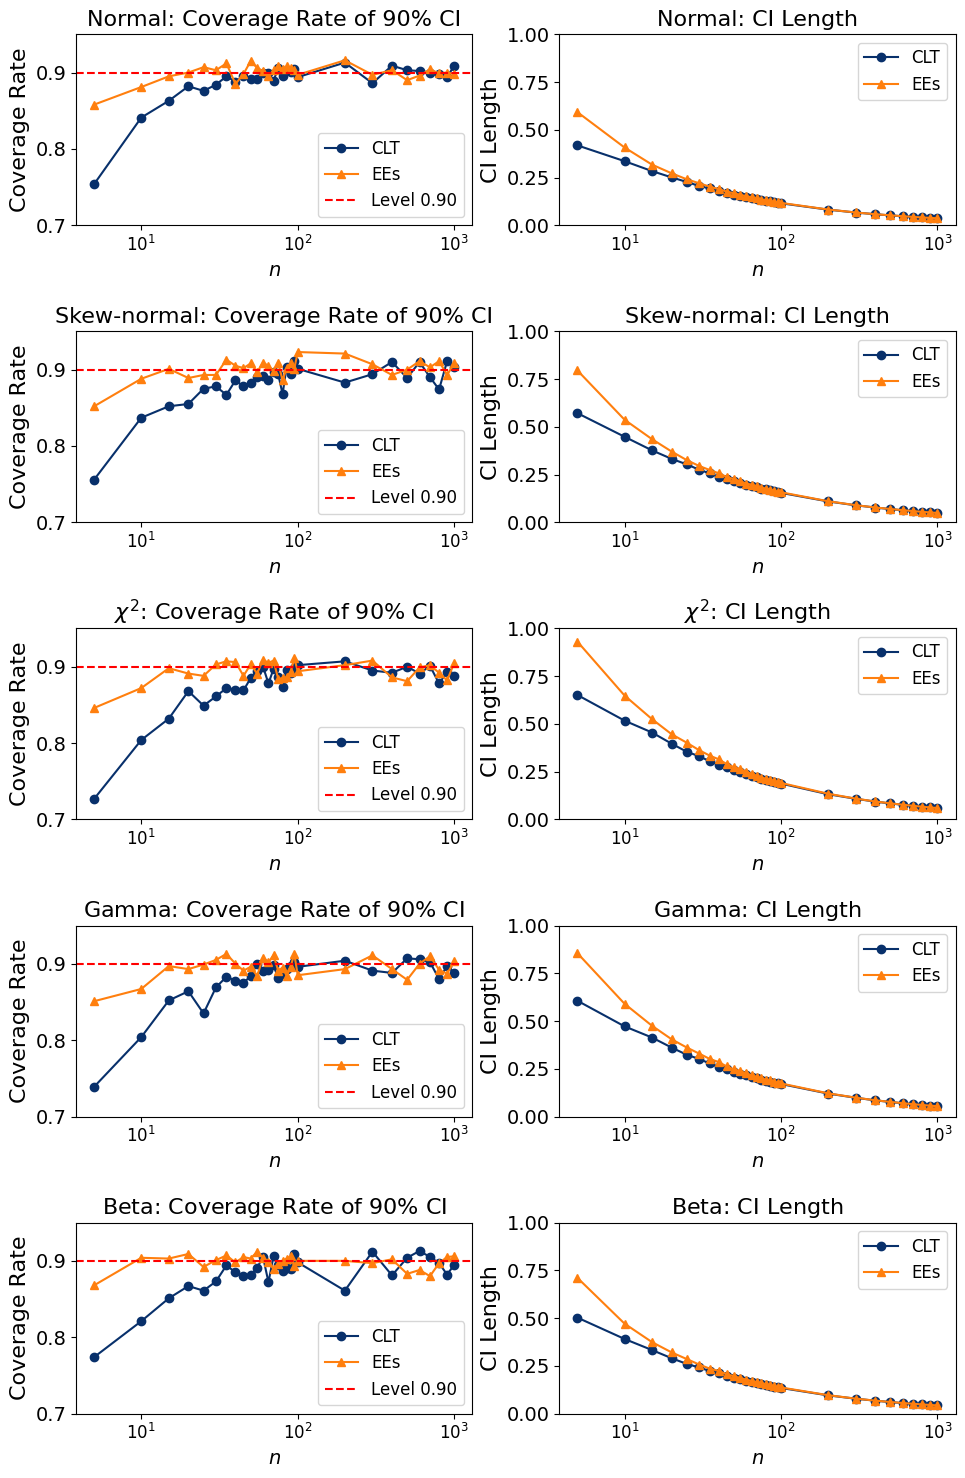

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.1
colors = {
    'EEs': '#ff7f0e',  
    'CLT': '#08306b'   
}
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10]))
jj = 0
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

Names = {
    'normal': 'Normal',
    'skewnorm': 'Skew-normal',
    'chi2': r'$\chi^2$',       
    'gamma': r'$\mathrm{Gamma}$',
    'beta': r'$\mathrm{Beta}$'   
}
names = ['normal', 'skewnorm', 'chi2', 'gamma', 'beta']
for name in names:
    ees_cov, ees_pwr, ees_ci = results_ees[name]
    clt_cov, clt_pwr, clt_ci = results_clt[name]

    axes[jj, 0].plot(num_list, clt_cov, marker='o',
                     label='CLT', color=colors['CLT'])
    axes[jj, 0].plot(num_list, ees_cov, marker='^',
                     label='EEs', color=colors['EEs'])

    axes[jj, 1].plot(num_list, clt_ci, marker='o',
                     label='CLT', color=colors['CLT'])
    axes[jj, 1].plot(num_list, ees_ci, marker='^',
                     label='EEs', color=colors['EEs'])

    for ax in [axes[jj, 0], axes[jj, 1]]:
        ax.set_xscale('log')
        tick_locations = [10, 100, 1000]
        tick_labels = [r'$10^1$', r'$10^2$', r'$10^3$']
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(tick_labels, fontsize=12)
        ax.set_xticks([], minor=True)

    axes[jj, 0].axhline(1-alpha, color='red', linestyle='--',
                        label=f'Level {1-alpha:.2f}')
    axes[jj, 0].set_xlabel(r'$n$', fontsize=14)
    axes[jj, 0].set_ylabel('Coverage Rate')
    axes[jj, 0].set_title(f'{Names[name]}: Coverage Rate of 90% CI')
    axes[jj, 0].set_ylim(0.7, 0.95)
    axes[jj, 0].legend(prop={'size': 12})


    axes[jj, 1].set_xlabel(r'$n$', fontsize=14)
    axes[jj, 1].set_ylabel('CI Length')
    axes[jj, 1].set_title(f'{Names[name]}: CI Length')
    axes[jj, 1].set_ylim(0, 1)
    axes[jj, 1].legend(prop={'size': 12})

    jj += 1

plt.tight_layout()
plt.savefig("linear_unknown_optimal_final.png", dpi=500)
plt.savefig("linear_unknown_optimal_final.eps", dpi=500)
plt.show()

### (2) $g(Z)=\text{Sigmoid}(Z)$, unknown variance

#### EEs

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm, skew, kurtosis, expon
import pickle
from scipy.stats import skewnorm, norm, expon, chi2, gamma, beta

def H2(x): return x**2 - 1
def H3(x): return x**3 - 3*x
def H5(x): return x**5 - 10*x**3 + 15*x


def edgeworth_unknownvar_cdf(x, n, kappa3, kappa4): 
    """未知方差版本 Edgeworth CDF（对标准化统计量近似）"""
    x = np.asarray(x, dtype=float)
    Phi = norm.cdf(x)
    phi = norm.pdf(x)

    term1 = (n**-0.5) * (kappa3 / 6.0) * (2*x**2 + 1) * phi
    term2 = (n**-1.0) * ((kappa4 / 12.0) * x * (x**2 - 3) -
                         (kappa3**2 / 18.0) * x * (x**4 + 2*x**2 - 3) - 1 / 4.0 * x * (x**2 + 3)) * phi
    Fn = Phi + term1 + term2
    return np.clip(Fn, 1e-12, 1-1e-12)


def xi_from_g(Y0, A1_vec, B1, A2_vec, B2):
    g1 = (Y0 - B1) / A1_vec
    g2 = (Y0 - B2) / A2_vec
    return -0.5 * np.sum(g1**2, axis=1) + 0.5 * np.sum(g2**2, axis=1)

np.random.seed(1)
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10]))
dim = 10
A1_vector = np.random.uniform(0.8, 1.2, dim)
B1_bias = np.random.normal(0, 1, dim)
eps = 0.07
alpha = 0.1
PATH_EES = './result_sigmoid_ees_unknown_optimal'
os.makedirs(PATH_EES, exist_ok=True)

a = 5
m = skewnorm.mean(a)
s = skewnorm.std(a)
chi2_df = 5
gamma_shape = 4.0
gamma_scale = 1.0
beta_a = 2.0
beta_b = 5.0
m_chi2 = chi2.mean(df=chi2_df)
s_chi2 = chi2.std(df=chi2_df)
m_gamma = gamma.mean(a=gamma_shape, scale=gamma_scale)
s_gamma = gamma.std(a=gamma_shape, scale=gamma_scale)
m_beta = beta.mean(a=beta_a, b=beta_b)
s_beta = beta.std(a=beta_a, b=beta_b)
samplers = {
    'normal': lambda size, rng=None: (rng or np.random).normal(0, 1, size),
    'skewnorm': lambda size, rng=None: (skewnorm.rvs(a=a, size=size, random_state=rng) - m) / s,
    'chi2': lambda size, rng=None: ((rng or np.random).chisquare(df=chi2_df, size=size) - m_chi2) / s_chi2,
    'gamma': lambda size, rng=None: ((rng or np.random).gamma(shape=gamma_shape, scale=gamma_scale, size=size) - m_gamma) / s_gamma,
    'beta': lambda size, rng=None: ((rng or np.random).beta(a=beta_a, b=beta_b, size=size) - m_beta) / s_beta,
}
names = ['normal', 'skewnorm', 'chi2', 'gamma', 'beta']

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    sigmoid = 1.0 / (1.0 + np.exp(-Z))
    Y = sigmoid * A1_vec + B1   
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())

TRUE = {name: [] for name in names}
for name in names:
    TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])

for name in names:
    for iter_index, num_data in enumerate(num_list):
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps
        C_const = np.sum(np.log(A2_vector / A1_vector))

        num_rep = 1000
        Xbar, K3, K4 = np.zeros(num_rep), np.zeros(num_rep), np.zeros(num_rep)
        Xvar = np.zeros(num_rep)

        for rep in range(num_rep):
            rng = np.random.RandomState(iter_index * 1000 + rep)
            Z0 = samplers[name]((num_data, dim), rng=rng)
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            Y0 = sigmoid0 * A1_vector + B1_bias  
            X = xi_from_g(Y0, A1_vector, B1_bias, A2_vector, B2_bias)

            Xbar[rep] = X.mean()
            xvar = X.var(ddof=0)
            Xvar[rep] =  xvar 

            if np.allclose(xvar, 0.0):
                K3[rep], K4[rep] = 0.0, 0.0
            else:
                k3 = float(skew(X, bias=False))
                k3 = k3 if np.isfinite(k3) else 0.0
                k4 = float(kurtosis(X, fisher=True, bias=False))
                k4 = k4 if np.isfinite(k4) else 0.0
                K3[rep], K4[rep] = k3, k4

        with open(f"{PATH_EES}/{name}_num_{iter_index}_ees_sigmoid_optimal.pt", 'wb') as f:
            pickle.dump([C_const, Xbar, Xvar, K3, K4, float(eps), num_data], f)

results_ees = {}
for name in names:
    cov, pwr, CI_len = [], [], []
    for i, num_data in enumerate(num_list):
        with open(f"{PATH_EES}/{name}_num_{i}_ees_sigmoid_optimal.pt", 'rb') as f:
            C_const, Xbar, Xvar, K3, K4, eps_val, n = pickle.load(f)

        td = TRUE[name]
        sigma_unknown = np.sqrt(Xvar)

        if np.allclose(sigma_unknown, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        q_lo = np.zeros_like(Xbar)
        q_hi = np.zeros_like(Xbar)
        for j in range(len(Xbar)):
            k3 = K3[j] if np.isfinite(K3[j]) else 0.0
            k4 = K4[j] if np.isfinite(K4[j]) else 0.0
            q_lo[j], q_hi[j], _ = calculate_shortest_confidence_interval(
                alpha, n, k3, k4, method='hdi_optimization')

        mu_lower = Xbar - sigma_unknown/np.sqrt(n) * q_hi
        mu_upper = Xbar - sigma_unknown/np.sqrt(n) * q_lo
        lower, upper = C_const + mu_lower, C_const + mu_upper
        cov.append(np.mean((lower <= td) & (td <= upper)))
        CI_len.append(np.mean(upper - lower))

        T_obs = np.sqrt(n) * (Xbar + C_const) / sigma_unknown
        T_abs = np.abs(T_obs)
        F_pos = edgeworth_unknownvar_cdf(T_abs, n, K3, K4)
        F_neg = edgeworth_unknownvar_cdf(-T_abs, n, K3, K4)
        pval = (1.0 - F_pos) + F_neg
        pval = np.clip(pval, 0.0, 1.0)
        pwr.append(np.mean(pval < alpha))

    results_ees[name] = (np.array(cov), np.array(pwr), np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_ees_unknown_optimal.pt", 'wb') as f:
    pickle.dump(results_ees, f)

#### CLT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm, expon
from scipy.stats import skewnorm, norm, expon, chi2, gamma, beta

np.random.seed(1)
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10]))
dim = 10
A1_vector = np.random.uniform(0.8, 1.2, dim)
B1_bias = np.random.normal(0, 1, dim)
eps = 0.07
alpha = 0.10
z = norm.ppf(1 - alpha/2)
PATH         = './result_sigmoid_clt_optimal'
os.makedirs(PATH, exist_ok=True)


a = 5
m = skewnorm.mean(a)
s = skewnorm.std(a)
chi2_df = 5
gamma_shape = 4.0
gamma_scale = 1.0
beta_a = 2.0
beta_b = 5.0
m_chi2 = chi2.mean(df=chi2_df)
s_chi2 = chi2.std(df=chi2_df)
m_gamma = gamma.mean(a=gamma_shape, scale=gamma_scale)
s_gamma = gamma.std(a=gamma_shape, scale=gamma_scale)
m_beta = beta.mean(a=beta_a, b=beta_b)
s_beta = beta.std(a=beta_a, b=beta_b)
samplers = {
    'normal': lambda size, rng=None: (rng or np.random).normal(0, 1, size),
    'skewnorm': lambda size, rng=None: (skewnorm.rvs(a=a, size=size, random_state=rng) - m) / s,
    'chi2': lambda size, rng=None: ((rng or np.random).chisquare(df=chi2_df, size=size) - m_chi2) / s_chi2,
    'gamma': lambda size, rng=None: ((rng or np.random).gamma(shape=gamma_shape, scale=gamma_scale, size=size) - m_gamma) / s_gamma,
    'beta': lambda size, rng=None: ((rng or np.random).beta(a=beta_a, b=beta_b, size=size) - m_beta) / s_beta,
}
names = ['normal', 'skewnorm', 'chi2', 'gamma', 'beta']

def xi_from_g(Y0, A1_vec, B1, A2_vec, B2):
    g1 = (Y0 - B1) / A1_vec
    g2 = (Y0 - B2) / A2_vec
    return -0.5 * np.sum(g1**2, axis=1) + 0.5 * np.sum(g2**2, axis=1)

for name, sampler in samplers.items():
    for iter_index, num_data in enumerate(num_list):
        np.random.seed(iter_index)
        A2_vector, B2_bias = A1_vector * (1 + eps), B1_bias + eps

        delta_list = np.zeros(1000)
        std_list   = np.zeros(1000)

        for seed in range(1000):
            np.random.seed(iter_index * 1000 + seed)
            Z0 = sampler((num_data, dim)); Z2 = sampler((num_data, dim))
            sigmoid0 = 1.0 / (1.0 + np.exp(-Z0))
            sigmoid2 = 1.0 / (1.0 + np.exp(-Z2))
            Y0 = sigmoid0 * A1_vector + B1_bias
            Y2 = sigmoid2 * A2_vector + B2_bias   
            g1, g2 = (Y0 - B1_bias) / A1_vector, (Y0 - B2_bias) / A2_vector

            delta_pp = (
                np.log(np.abs(A2_vector / A1_vector)).sum()
                - 0.5 * (g1**2).sum(1).mean()
                + 0.5 * (g2**2).sum(1).mean()
            )
            std_pp = ((-0.5 * (g1**2).sum(1) + 0.5 * (g2**2).sum(1)).std() / np.sqrt(num_data))
            delta_list[seed], std_list[seed] = delta_pp, std_pp

        with open(f"{PATH}/{name}_num_{iter_index}_result_optimal.pt", 'wb') as f:
            pickle.dump([delta_list, std_list, num_data], f)

def delta_true_mc(name, eps, A1_vec, B1, big_n=200_000, seed=20240814):
    rng = np.random.RandomState(seed)
    Z = samplers[name]((big_n, dim), rng=rng)
    sigmoid = 1.0 / (1.0 + np.exp(-Z))
    Y = sigmoid * A1_vec + B1
    A2 = A1_vec * (1 + eps)
    B2 = B1 + eps
    X = xi_from_g(Y, A1_vec, B1, A2, B2)
    C = np.sum(np.log(A2 / A1_vec))
    return float(C + X.mean())


TRUE = {name: [] for name in names}
for name in names:
    TRUE[name].append(delta_true_mc(name, eps, A1_vector, B1_bias))
    TRUE[name] = np.array(TRUE[name])

results_clt = {}
for name in names:
    cov = []; pwr = []; CI_len = []
    for i, num_data in enumerate(num_list):
        with open(f"{PATH}/{name}_num_{i}_result_optimal.pt", 'rb') as f:
            delta_list, std_list, num_data = pickle.load(f)
        delta_arr, std_arr = np.asarray(delta_list), np.asarray(std_list)

        if np.allclose(std_arr, 0.0):
            cov.append(1.0)
            pwr.append(0.0)
            CI_len.append(0.0)
            continue

        td = TRUE[name]
        lower, upper = delta_arr - z*std_arr, delta_arr + z*std_arr
        cov.append(np.mean((lower <= td) & (td <= upper)))
        pwr.append(np.mean((upper < 0) | (lower > 0)))
        CI_len.append(np.mean(upper - lower))
    results_clt[name] = (np.array(cov), np.array(pwr),np.array(CI_len))

metrics_path = './metrics'
os.makedirs(metrics_path, exist_ok=True)
with open(f"{metrics_path}/metric_sigmoid_clt_unknown_optimal.pt", 'wb') as f:
    pickle.dump(results_clt, f)

#### plots

In [ ]:
import pickle
metrics_path = './metrics'
with open(f"{metrics_path}/metric_sigmoid_ees_unknown_optimal.pt", 'rb') as f:
    results_ees = pickle.load(f)
with open(f"{metrics_path}/metric_sigmoid_clt_unknown_optimal.pt", 'rb') as f:
    results_clt = pickle.load(f)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


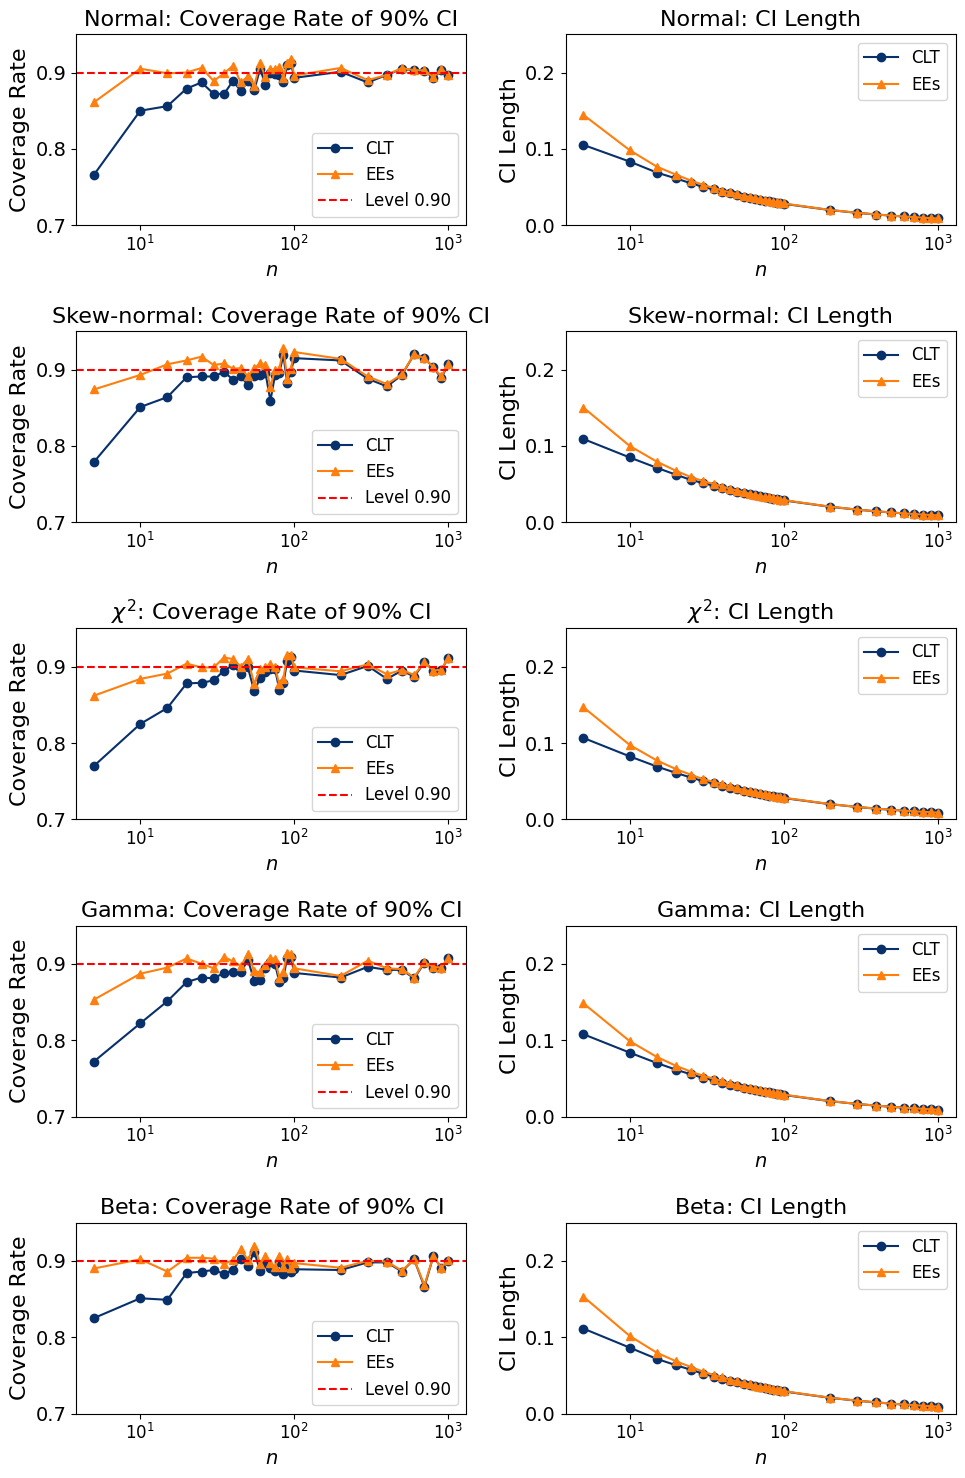

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.1
colors = {
    'EEs': '#ff7f0e',  
    'CLT': '#08306b'   
}
num_list = np.concatenate(
    (np.arange(5, 105, 5)[:19], np.arange(100, 1100, 100)[:10]))
jj = 0
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

Names = {
    'normal': 'Normal',
    'skewnorm': 'Skew-normal',
    'chi2': r'$\chi^2$',       
    'gamma': r'$\mathrm{Gamma}$', 
    'beta': r'$\mathrm{Beta}$'   
}

for name in names:
    ees_cov, ees_pwr, ees_ci = results_ees[name]
    clt_cov, clt_pwr, clt_ci = results_clt[name]
    axes[jj, 0].plot(num_list, clt_cov, marker='o',
                     label='CLT', color=colors['CLT'])
    axes[jj, 0].plot(num_list, ees_cov, marker='^',
                     label='EEs', color=colors['EEs'])

    axes[jj, 1].plot(num_list, clt_ci, marker='o',
                     label='CLT', color=colors['CLT'])
    axes[jj, 1].plot(num_list, ees_ci, marker='^',
                     label='EEs', color=colors['EEs'])
    for ax in [axes[jj, 0], axes[jj, 1]]:
        ax.set_xscale('log')
        tick_locations = [10, 100, 1000]
        tick_labels = [r'$10^1$', r'$10^2$', r'$10^3$']
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(tick_labels, fontsize=12)
        ax.set_xticks([], minor=True)
    axes[jj, 0].axhline(1-alpha, color='red', linestyle='--',
                        label=f'Level {1-alpha:.2f}')
    axes[jj, 0].set_xlabel(r'$n$', fontsize=14)
    axes[jj, 0].set_ylabel('Coverage Rate')
    axes[jj, 0].set_title(f'{Names[name]}: Coverage Rate of 90% CI')
    axes[jj, 0].set_ylim(0.7, 0.95)
    axes[jj, 0].legend(prop={'size': 12},loc = 'lower right')


    axes[jj, 1].set_xlabel(r'$n$', fontsize=14)
    axes[jj, 1].set_ylabel('CI Length')
    axes[jj, 1].set_title(f'{Names[name]}: CI Length')
    axes[jj, 1].set_ylim(0, 0.25)
    axes[jj, 1].legend(prop={'size': 12})
    jj += 1

plt.tight_layout()
plt.savefig("sigmoid_unknown_optimal.png", dpi=500)
plt.savefig("sigmoid_unknown_optimal.eps", dpi=500)
plt.show()